# Enhancing Robustness in EEG Seizure Detection with Topological Feature Representations and Supervised Learning

## INITIALIZATION

### Setting up directories

In [1]:
print("hello")


hello


In [1]:
import sys
print("Python Executable:", sys.executable)
print("\nUser site-packages:", sys.path)


Python Executable: /home/ab/miniconda3/envs/seizure_env/bin/python

User site-packages: ['/home/ab/miniconda3/envs/seizure_env/lib/python311.zip', '/home/ab/miniconda3/envs/seizure_env/lib/python3.11', '/home/ab/miniconda3/envs/seizure_env/lib/python3.11/lib-dynload', '', '/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages']


In [2]:
import os
import sys 
sys.path.append("../src")
# Create a directory to save the models

os.makedirs('models', 
exist_ok=True)
# Create a directory to save the metrics
os.makedirs('metrics', exist_ok=True)
# Create a directory to save the images
os.makedirs('images', exist_ok=True)


def folder_size(path='.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size

size_bytes = folder_size('models')
size_mb = size_bytes / (1024 * 1024)
print(f"Size of results folder: {size_mb:.2f} MB")


Size of results folder: 0.01 MB


### Loading required packages

In [3]:
# Common utility libraries
import time
import random
import joblib
import itertools
import warnings
import glob, re
from collections import Counter

# Common data science libraries
import numpy as np 
import pandas as pd
import scipy as sp 

# Common visualisations libraries
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm # Color map
import matplotlib.colors as colors 

# Feature Extraction libraries
import pywt
from sklearn.model_selection import train_test_split

# TDA libraries
import persim
from persim import PersistenceImager

from ripser import ripser

import gudhi
from gudhi import bottleneck_distance
from gudhi.wasserstein import wasserstein_distance


import networkx as nx # For drawing the network diagram of distances

from visualization import plot_class_signals, plot_class_distribution, plot_persistence_images, plot_confusion_matrix, plot_persistence_diagrams_from_data
from preprocessing import normalize_data, map_class_labels, artifact_noise
from feature_engineering import FeatureExtractor, extract_fft_features, extract_wavelet_features, get_wavelet_features, get_tda_features_and_labels, get_features_and_labels, get_extractors_methods, gaussian_noise
from ml_pipeline import get_train_test_data, generate_classification_report, train_and_tune_model, split_and_flatten_persistence_images
from run_experiments import run_logistic_regression, run_ridge_classifier, run_knn_classifier, run_sgd_classifier, run_random_forest_classifier, run_mlp_classifier, run_xgboost_classifier, run_svc_classifier, run_catboost_classifier, run_model_on_features, run_model_fft_xgboost, run_model_base_dwt_tda_xgboost
from tda_distances import compute_persistence_diagrams_from_dataframe, bottleneck, bottleneck_between_class, bottleneck_within_class, bottleneck_distance

# Set global variables
%matplotlib inline
## Temporarily comment out the following line (this global pimager definition). The actual PersistenceImager should be instantiated and 
## configured within the new TDA feature generation function, after you have a sense of the typical birth/death ranges of diagrams from 
## your new Takens' embedding approach.
# pimager = PersistenceImager(pixel_size=0.2)

warnings.filterwarnings("ignore", category=RuntimeWarning)
mpl.rcParams['text.usetex'] = False


# Setting the random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# check if TDA packages are working
print("GUDHI:",gudhi.__version__)
print("persim:",persim.__version__)


GUDHI: 3.10.1
persim: 0.3.8


### Reading in the raw data

We have downloaded the NPY files from https://data.mendeley.com/datasets/5pc2j46cbc/1

These are the files x_test.npy, x_train.npy, y_test.npy, y_train.npy. These files were obtained by preprocessing the raw EDF files (also provided in the dataset) using preprocessing.py (https://data.mendeley.com/datasets/5pc2j46cbc/1/files/56ef90d9-04bb-4d02-bff8-7472cc1e8cbb)

The following code takes EEG data stored as 3D NumPy arrays and converts them into CSV files suitable for machine learning, applying two key preprocessing steps along the way.

The X Input Data Structure (from the npy files) is a 3D NumPy array with shape (segments, channels, samples). Each segment represents a time window (like your 1-second windows). Each channel represents an EEG electrode/channel, Each sample represents a time point (500 samples in your case)

The Y data is/are 1D NumPy array/s with labels for each segment

Key Processing Steps
1. Data Reshaping: The code "flattens" the 3D structure by treating each channel of each segment as a separate univariate time series. So if you have 10 segments with 19 channels each, you get 190 individual time series rows in the CSV. Although EEG channels capture signals from different scalp regions (e.g., frontal, temporal, occipital), each with unique noise profiles and physiological artifacts, we can treat the 19 channels as individual time series with the same dynamical properties (like signal complexity and nonlinearity) since these are consistent across channels for the same subject/task due to shared neural generators and volume conduction. Preprocessing parameters can be global because biological noise (e.g., muscle artifacts, eye blinks) affects all channels similarly, while seizures manifest as synchronized bursts across multiple channels, preserving embedding topology.
2. Label Conversion: Converts multi-class labels (0, 1, 2, 3, etc.) into binary labels (0 for non-seizure, 1 for seizure), where anything that wasn't originally 0 becomes 1.
3. Baseline Correction: Subtracts the mean from each time series to center it around zero. The purpose is to remove any remaining DC offset or very slow drift within the 1-second epoch. This "zeros" the data.
4. Per-Segment Z-score Normalization: Standardizes each time series to have mean=0 and standard deviation=1. The purpose is to ensure each 1-second segment has a similar dynamic range or distribution. This is crucial for many ML algorithms and feature extraction methods that are sensitive to feature scales (e.g., TDA persistence image generation if it involves distance calculations, KNN). This step effectively standardizes each 1-second window independently. The script that transformed the raw EDF data intoNPY files did group-wise max-abs scaling. When you combine these groups, the absolute values might still differ significantly. Scaling each 1-second segment individually ensures they are all on a comparable footing before feature extraction.

The following list gives reasons why Baseline Correction (mean subtraction) is often recommended as a separate step even if Z-score Normalization is done after:
1. Conceptual Clarity & Order of Operations: The idea is often to first remove any overall offset (center the signal around zero) to represent pure AC fluctuations. Also, denoising algorithms (like the wavelet denoising I suggested) might behave more predictably or effectively on data that is already zero-mean as the characteristics of noise might be more easily separable from a signal that doesn't have a large DC component. Lastly, normalization/scaling is then applied to the cleaned, centered signal to bring different epochs/channels to a comparable dynamic range for the ML model.
2. Interpretation of Features (if extracted before final scaling):
If you were to extract certain features (e.g., variance, power) from the signal after baseline correction but before Z-score scaling, these features would be calculated on zero-mean data. Power, for example, is directly affected by a DC offset. Removing the offset ensures you're calculating the power of the fluctuations. While Z-scoring also removes the mean, if features are extracted at an intermediate stage, the initial baseline correction is beneficial.
3. Historical Practice & Robustness:
Baseline correction is a very standard step in EEG processing, especially for Event-Related Potentials (ERPs), where a pre-stimulus baseline is used. For continuous data segmented into epochs, subtracting the epoch's own mean is the analogous step. It's often done as a foundational "hygiene" step.
4. Flexibility in Normalization Choice:
If you perform baseline correction (mean subtraction) first, you have a centered signal. You can then decide to apply Z-score, Min-Max, or another scaling method without worrying about the centering aspect again.

Output Format
Creates CSV files with this column structure:

Unnamed: Segment identifier (e.g., "Train_Seg0_Ch0")

X1, X2, ..., X500: The 500 time series sample values (preprocessed)

y: Binary label (0 or 1)



In [6]:
#import numpy as np
#import os
import csv

def create_separate_processed_csvs(x_data_path, y_data_path, set_prefix, output_csv_path):
    """
    Processes a single dataset (.npy files for x and y), applies baseline correction
    and per-segment Z-score normalization, and then creates a CSV file.
    The CSV format is: 'Unnamed' for segment ID, 'X1', 'X2', ... for samples,
    and 'y' for the label.

    Args:
        x_data_path (str): Path to the x_data.npy file.
        y_data_path (str): Path to the y_data.npy file.
        set_prefix (str): Prefix for segment IDs (e.g., "Train" or "Test").
        output_csv_path (str): Path for the output CSV file for this specific set.
    """
    print(f"\nStarting CSV creation for {set_prefix} set. Output will be: {output_csv_path}")
    print(f"  Applying: 1. Baseline Correction (mean subtraction), 2. Per-Segment Z-score Normalization")

    # --- Step 1: Load Data ---
    try:
        x_data = np.load(x_data_path)
        y_labels_original = np.load(y_data_path)
        print(f"  Loaded {x_data_path}, shape: {x_data.shape}")
        print(f"  Loaded {y_data_path}, shape: {y_labels_original.shape}")
    except FileNotFoundError:
        print(f"  Error: Could not find {x_data_path} or {y_data_path}. Skipping CSV creation for this set.")
        return

    # --- Step 2: Validate Data Dimensions ---
    if x_data.ndim != 3:
        print(f"  Error: {x_data_path} is not a 3D array as expected. Shape is {x_data.shape}. Skipping.")
        return
    if y_labels_original.ndim != 1:
        print(f"  Error: {y_data_path} is not a 1D array as expected. Shape is {y_labels_original.shape}. Skipping.")
        return
    if x_data.shape[0] != y_labels_original.shape[0]:
        print(f"  Error: Number of segments in {x_data_path} ({x_data.shape[0]}) "
              f"does not match labels in {y_data_path} ({y_labels_original.shape[0]}). Skipping.")
        return

    # --- Step 3: Determine Header ---
    num_samples_per_series = x_data.shape[2]
    header = ['Unnamed'] + [f'X{i+1}' for i in range(num_samples_per_series)] + ['y']

    # --- Step 4: Open CSV file for writing ---
    with open(output_csv_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(header) # Write header
        print(f"  CSV Header written: 'Unnamed', X1...X{num_samples_per_series}, 'y'.")

        # --- Step 5: Convert Labels and Process Data ---
        y_labels_binary = np.where(y_labels_original == 0, 0, 1)
        print(f"  Converted labels to binary. Unique binary labels: {np.unique(y_labels_binary)}")

        num_segments = x_data.shape[0]
        num_channels = x_data.shape[1]

        for seg_idx in range(num_segments):
            current_segment_label = y_labels_binary[seg_idx]
            for chan_idx in range(num_channels):
                segment_id = f"{set_prefix}_Seg{seg_idx}_Ch{chan_idx}"
                univariate_series_original = x_data[seg_idx, chan_idx, :]

                # --- Preprocessing Steps ---
                # 1. Baseline Correction: Subtract the mean
                mean_val = np.mean(univariate_series_original)
                baseline_corrected_series = univariate_series_original - mean_val

                # 2. Per-Segment Normalization: Apply Z-score scaling
                std_dev = np.std(baseline_corrected_series)
                if std_dev == 0: # Avoid division by zero for flat signals (all values are the same after mean subtraction)
                    # If std_dev is 0, the signal is constant (all zeros after baseline correction).
                    # Z-score would be NaN or Inf. We can keep it as all zeros.
                    processed_series = baseline_corrected_series
                else:
                    processed_series = (baseline_corrected_series - np.mean(baseline_corrected_series)) / std_dev
                    # Note: np.mean(baseline_corrected_series) should be very close to 0,
                    # so this is effectively baseline_corrected_series / std_dev

                # Row: Segment ID, X1, X2, ..., XN, label
                row_to_write = [segment_id] + list(processed_series) + [current_segment_label]
                csv_writer.writerow(row_to_write)

            if (seg_idx + 1) % 100 == 0 or (seg_idx + 1) == num_segments: # Progress update
                print(f"    Processed {seg_idx + 1}/{num_segments} segments from {set_prefix} set...")
        print(f"  Finished processing {set_prefix} data. Wrote {num_segments * num_channels} univariate series rows to {output_csv_path}")


In [7]:
# Configuration and execution
base_data_dir = "./npy_files"

# File paths
paths = {
    'train': {
        'x': os.path.join(base_data_dir, "x_train.npy"),
        'y': os.path.join(base_data_dir, "y_train.npy"),
        'output': "./train_data_processed_preexisting_format.csv"
    },
    'test': {
        'x': os.path.join(base_data_dir, "x_test.npy"),
        'y': os.path.join(base_data_dir, "y_test.npy"),
        'output': "./test_data_processed_preexisting_format.csv"
    }
}

# Execute processing
for dataset_name, dataset_paths in paths.items():
    create_separate_processed_csvs(
        dataset_paths['x'], 
        dataset_paths['y'], 
        dataset_name.capitalize(), 
        dataset_paths['output']
    )

print("All processed CSV files created successfully.")


Starting CSV creation for Train set. Output will be: ./train_data_processed_preexisting_format.csv
  Applying: 1. Baseline Correction (mean subtraction), 2. Per-Segment Z-score Normalization
  Error: Could not find ./npy_files/x_train.npy or ./npy_files/y_train.npy. Skipping CSV creation for this set.

Starting CSV creation for Test set. Output will be: ./test_data_processed_preexisting_format.csv
  Applying: 1. Baseline Correction (mean subtraction), 2. Per-Segment Z-score Normalization
  Error: Could not find ./npy_files/x_test.npy or ./npy_files/y_test.npy. Skipping CSV creation for this set.
All processed CSV files created successfully.


In [4]:
import pandas as pd # Ensure pandas is imported if this is the first pandas call in a new script/session

# Load train_data_processed_preexisting_format.csv and call the DataFrame df_train_full.
# The test data will be loaded as df_test_full

# Load your pre-defined train and test CSVs
try:
    df_train_full = pd.read_csv("train_data_processed_preexisting_format.csv") # ADJUST PATH
    df_test_full = pd.read_csv("test_data_processed_preexisting_format.csv")   # ADJUST PATH
    print("Successfully loaded df_train_full and df_test_full.")
    print("Shape of df_train_full:", df_train_full.shape)
    print("Shape of df_test_full:", df_test_full.shape)
except FileNotFoundError:
    print("ERROR: Training or testing CSV file not found. Please check paths.")
    raise # Stop execution if data isn't loaded

# Assuming your label column is 'y'.
target = 'y'

# Define predictor columns
# This should work for your new CSV (Unnamed, X1...X500, y). Verify by printing.
if 'df_train_full' in locals(): # Check if df_train_full was loaded
    # The first column is 'Unnamed', so data.columns.to_list()[1:] starts from 'X1'
    # and goes up to 'y'. Then 'y' is removed.
    predictors = df_train_full.columns.to_list()[1:] 
    if target in predictors:
        predictors.remove(target)
    else:
        print(f"Warning: Target column '{target}' not found in initial predictor list derived from columns [1:].")
        # Fallback or error handling might be needed if target isn't last or structure is unexpected.
        # For now, assuming 'X1' to 'X500' are correctly captured.
        # A more robust way if X columns are always named Xn:
        # predictors = [col for col in df_train_full.columns if col.startswith('X')]

    print(f"\nFirst 5 predictor columns: {predictors[:5]}")
    print(f"Last 5 predictor columns: {predictors[-5:]}")
    print(f"Target: '{target}', Number of predictors: {len(predictors)}") # Should be Target: y, Number of predictors: 500

    print("\nHead of df_train_full:")
    print(df_train_full.head())
else:
    print("Skipping predictor definition as df_train_full was not loaded.")


# Define binary class labels map (used by plotting and reports)
CLASS_LABELS_BINARY_MAP = {
    0: 'Normal', 
    1: 'Seizure'
}

# Placeholder for test data loading - this will be done later, before evaluation.
# df_test_full = None 
# try:
#     df_test_full = pd.read_csv("./test_data_processed_preexisting_format.csv") # ADJUST PATH AS NEEDED
#     print("\nSuccessfully loaded test_data_processed_preexisting_format.csv")
#     print("Shape of df_test_full:", df_test_full.shape)
# except FileNotFoundError:
#     print("ERROR: test_data_processed_preexisting_format.csv not found. Will attempt to load later if needed.")


Successfully loaded df_train_full and df_test_full.
Shape of df_train_full: (133209, 502)
Shape of df_test_full: (14801, 502)

First 5 predictor columns: ['X1', 'X2', 'X3', 'X4', 'X5']
Last 5 predictor columns: ['X496', 'X497', 'X498', 'X499', 'X500']
Target: 'y', Number of predictors: 500

Head of df_train_full:
          Unnamed        X1        X2        X3        X4        X5        X6  \
0  Train_Seg0_Ch0  0.016913  0.011354  0.015523  0.041928  0.093348  0.160055   
1  Train_Seg0_Ch1  1.147706  1.100758  1.070061  1.073673  1.124232  1.207294   
2  Train_Seg0_Ch2 -0.159233 -0.166152 -0.168458 -0.161539 -0.147701 -0.132710   
3  Train_Seg0_Ch3 -0.419138 -0.395264 -0.371391 -0.349506 -0.327622 -0.303749   
4  Train_Seg0_Ch4  0.305178  0.300836  0.313860  0.339908  0.392004  0.452783   

         X7        X8        X9  ...      X492      X493      X494      X495  \
0  0.223983  0.275402  0.310146  ...  0.058605  0.158665  0.250387  0.336551   
1  1.295772  1.364389  1.396891  ...  

Plotting signals. X_viz_binary shape: (133209, 500), y_viz_numeric_binary unique labels: [0 1]


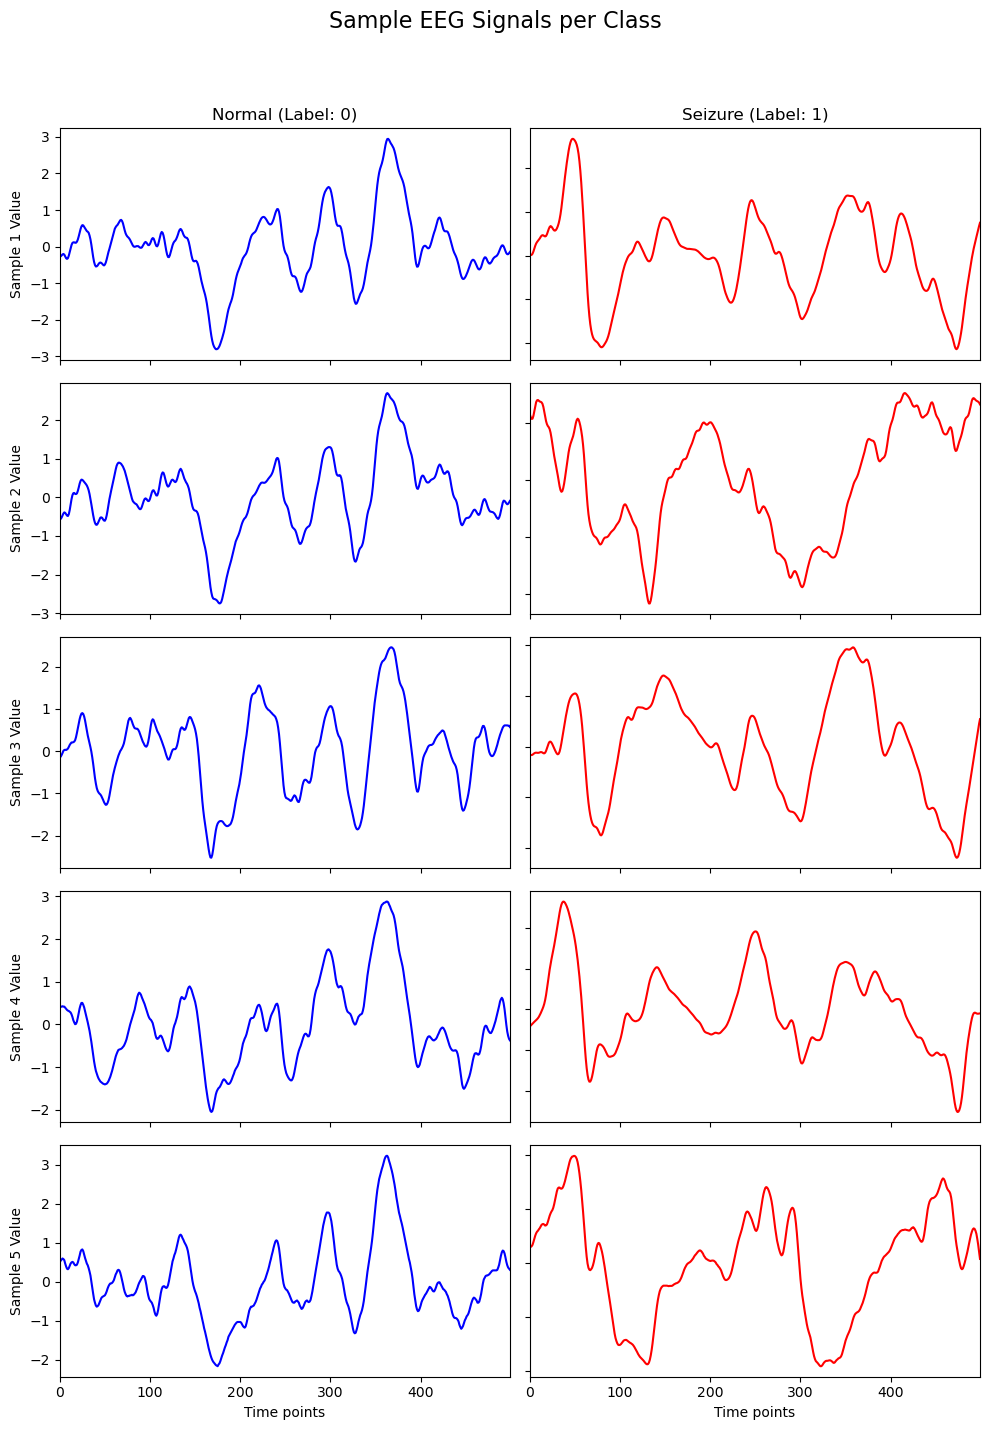

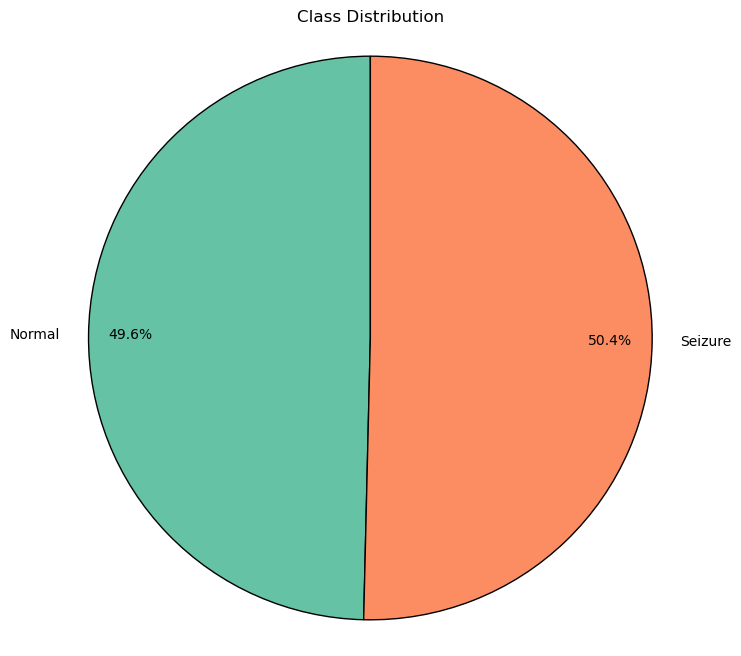

In [5]:
#df_viz = data.copy()
#class_labels = {
#    0: 'no seizure',
#    1: 'seizure activity'
#}
#df_viz['y'] = df_viz['y'].map(class_labels)
#X_viz = normalize_data(df_viz, predictors)  
#y_viz, _ =  get_features_and_labels(data)  

# Assuming df_train_full, predictors are defined
# And you have defined class_labels_binary = {0: 'Normal', 1: 'Seizure'}

if 'df_train_full' in locals() and 'predictors' in locals(): # Check if necessary DataFrames are loaded
    df_viz_binary = df_train_full.copy() 

    # === DEFINE class_labels_binary HERE ===
    class_labels_binary = {
        0: 'Normal',    # Assuming 0 is Normal in your 'y' column from the CSV
        1: 'Seizure'    # Assuming 1 is Seizure in your 'y' column from the CSV
    }
    # =======================================

    # Optional: Create a string version of labels if needed by other functions,
    # but plot_class_signals (as modified) can use the numeric y and the map.
    # df_viz_binary['y_str'] = df_viz_binary['y'].map(class_labels_binary) 

    X_viz_binary = df_viz_binary[predictors] # Using your pre-Z-scored data from the CSV
    y_viz_numeric_binary = df_viz_binary['y'].values # Get the numeric 0/1 labels

    # The plot_class_signals function is imported from your modified visualization.py
    # Ensure this import is successful and visualization.py is in the correct path (e.g., ../src)
    try:
        from visualization import plot_class_signals 
        
        print(f"Plotting signals. X_viz_binary shape: {X_viz_binary.shape}, y_viz_numeric_binary unique labels: {np.unique(y_viz_numeric_binary)}")

        plot_class_signals(
            X_viz_binary, 
            y_viz_numeric_binary, 
            class_labels_map=class_labels_binary, # Pass your binary label map
            samples_per_class=5, # Or fewer, e.g., 3 or 5
            signal_length=500 # Explicitly state signal length
        )
    except ImportError:
        print("ERROR: Could not import plot_class_signals from visualization.py. Check sys.path and file location.")
    except Exception as e:
        print(f"An error occurred during plotting: {e}")

else:
    print("df_train_full or predictors not defined. Skipping signal visualization.")



plot_class_distribution(
    df_train_full, # Pass the DataFrame with numeric 'y'
    label_column='y', # Specify the numeric label column
    class_labels_map=class_labels_binary # Pass your map for names and potential colors
)

#### Compute Takens Parameters

In [6]:
# Segment_Name   X1      X2      ...   X500   Label
# Train_Seg0_Ch0 0.123   0.456   ...   0.789  0
# Train_Seg0_Ch1 0.234   0.567   ...   0.890  0
# Test_Seg4_Ch18 0.345   0.678   ...   0.901  1

# The following code computes the Takens parameters with an input csv file that looks like the above comment

#Step 1: Load Data
import pandas as pd
import numpy as np

df = df_train_full.copy() 
series = df.iloc[:, 1:501].values  # Shape: (n_series, 500)
labels = df["y"].values            # Shape: (n_series,)

#Step 2: Create Balanced Subset
n_per_class = 100  # 100 seizure + 100 non-seizure

# Get indices for each class
class0_idx = np.where(labels == 0)[0]
class1_idx = np.where(labels == 1)[0]

# Randomly select 100 per class
subset_idx = np.concatenate([
    np.random.choice(class0_idx, n_per_class, replace=False),
    np.random.choice(class1_idx, n_per_class, replace=False)
])
subset_series = series[subset_idx]  # Shape: (200, 500)

#Step 3: Compute τ (Time Delay) via Mutual Information

from sklearn.metrics import mutual_info_score

def compute_mutual_info(ts, max_lag=50):
    mis = []
    for lag in range(1, max_lag + 1):
        x1 = ts[:-lag]
        x2 = ts[lag:]
        mi = mutual_info_score(None, None, contingency=np.histogram2d(x1, x2, bins=10)[0])
        mis.append(mi)
    # Find first local minimum
    for i in range(1, len(mis) - 1):
        if mis[i] < mis[i - 1] and mis[i] < mis[i + 1]:
            return i + 1  # τ = lag index
    return 1  # Default if no minimum

# Compute τ for each series in subset
taus = [compute_mutual_info(ts) for ts in subset_series]
global_tau = int(np.median(taus))  # Median τ for all series

print(f"Time Delay (tau) computed using mutual information: {global_tau}")

#Step 4: Compute d (Embedding Dimension) via False Nearest Neighbors
from sklearn.neighbors import NearestNeighbors

def false_nearest_neighbors(ts, tau, d_max=10, rtol=15, R_A=2.0): # Added R_A, a common FNN parameter
    n = len(ts)
    fnn_percentages = []

    # Pre-embed to maximum possible length needed for d_max
    # Max components needed = d_max + 1
    # Max length of embedded vector = (d_max) * tau (since it's (d_max-1)*tau for d_max-1 dim, and then one more tau step)
    # No, it's (d_max)*tau for the d_max dimensional vectors.
    # And (d_max+1-1)*tau = d_max*tau for the (d_max)-th component of (d_max+1) vector
    # Let's stick to your iterative embedding for now and fix the indexing.

    for d in range(1, d_max + 1): # Loop for current dimension 'd'
        # Construct d-dimensional embedding
        # Y_k = (x_k, x_{k+tau}, ..., x_{k+(d-1)tau})
        # Number of such points M = n - (d-1)*tau
        if n <= (d - 1) * tau: # Not enough points for this dimension
            fnn_percentages.append(1.0) # Indicate all are FNN or invalid
            continue
        
        embedding_d = np.array([ts[i : i + (d - 1) * tau + 1 : tau] for i in range(n - (d - 1) * tau)])
        if d == 1: # For d=1, embedding_d is (M, 1), make it (M,) for some FNN versions
            embedding_d = embedding_d.reshape(-1,1) # Ensure it's 2D for NearestNeighbors

        # Find nearest neighbors for each point in d-dimensional space
        # We only need one nearest neighbor (excluding the point itself)
        nn = NearestNeighbors(n_neighbors=2, algorithm='kd_tree')
        nn.fit(embedding_d)
        distances_d, indices_d = nn.kneighbors(embedding_d)

        # distances_d[:,1] are distances to nearest true neighbor
        # indices_d[:,1] are indices of nearest true neighbor (within embedding_d)

        # Now consider the (d+1)-th component
        # We need to check if adding x_{k+d*tau} causes a large jump
        
        num_fnn = 0
        num_valid_comparisons = 0

        for i in range(len(embedding_d)):
            neighbor_idx = indices_d[i, 1] # Index of the nearest neighbor in embedding_d

            # Check if both point i and its neighbor neighbor_idx can be extended to (d+1) dimensions
            # This means their original time series indices must allow for one more component x(t + d*tau)
            # Original time index for embedding_d[i] is 'i'
            # Original time index for embedding_d[neighbor_idx] is 'neighbor_idx'
            
            # The (d+1)-th component for point 'i' would be ts[i + d*tau]
            # The (d+1)-th component for point 'neighbor_idx' would be ts[neighbor_idx + d*tau]
            
            if (i + d * tau < n) and (neighbor_idx + d * tau < n):
                num_valid_comparisons += 1
                
                # Distance in d-dimensions (squared, to avoid sqrt initially)
                # dist_sq_d = np.sum((embedding_d[i] - embedding_d[neighbor_idx])**2)
                # Using the distance already found by NearestNeighbors is better
                dist_d_i_neighbor = distances_d[i, 1]
                if dist_d_i_neighbor == 0: # Avoid division by zero if points are identical
                    continue

                # Calculate distance in (d+1) dimensions
                # This is the squared Euclidean distance of the (d+1)th components,
                # added to the squared d-dimensional distance.
                # Or, more commonly, the ratio of the (d+1)-dim distance to d-dim distance.
                
                # Let's use the Kennel et al. criteria:
                # Criterion 1: R_d(i, tau) = || Y(i+1) - Y_nn(i+1) || / || Y(i) - Y_nn(i) || > R_tol
                # where Y(i) is d-dim, Y(i+1) is (d+1)-dim
                # This requires constructing (d+1) dim vectors and recalculating distances,
                # which is computationally more intensive than the "component-wise" check.
                
                # Your original approach was trying to compare:
                # || vectors_d1[i] - vectors_d1[neighbor_of_i_in_d_dim] || vs || vectors_d[i] - vectors_d[neighbor_of_i_in_d_dim] ||
                # The issue is `vectors_d1` is shorter.

                # Let's try to adapt your structure:
                # We need to compare point i and its d-dim neighbor (neighbor_idx)
                # *after* they are both projected to (d+1) dimensions, IF POSSIBLE.

                # Point i in (d+1) dim: ts[i : i + d*tau + 1 : tau]
                # Point neighbor_idx in (d+1) dim: ts[neighbor_idx : neighbor_idx + d*tau + 1 : tau]
                
                # This check was already done: (i + d * tau < n) and (neighbor_idx + d * tau < n)
                
                vec_i_d1 = ts[i : i + d * tau + 1 : tau]
                vec_neighbor_d1 = ts[neighbor_idx : neighbor_idx + d * tau + 1 : tau]

                dist_d1_i_neighbor = np.linalg.norm(vec_i_d1 - vec_neighbor_d1)

                if (dist_d1_i_neighbor / dist_d_i_neighbor) > rtol:
                    num_fnn += 1
                
                # Second FNN criterion (Kennel et al.): Check if (d+1)-dim distance exceeds overall attractor size
                # R_A is often standard deviation of the original time series.
                # if dist_d1_i_neighbor > R_A * np.std(ts): # This is another heuristic
                #    if not ((dist_d1_i_neighbor / dist_d_i_neighbor) > rtol): # Only count if not already FNN by first rule
                #        num_fnn += 1
                        
            # else: point i or its neighbor cannot be extended to d+1 dimensions, skip.

        if num_valid_comparisons > 0:
            fnn_percentages.append(num_fnn / num_valid_comparisons)
        else:
            fnn_percentages.append(1.0) # No valid comparisons, assume all FNN or d is too large

        # Stop if fraction drops below a threshold (e.g., 5% or 1%)
        if fnn_percentages[-1] < 0.05: # Or some other small threshold
            return d # Current dimension 'd' is good

    # If no dimension clearly drops FNN below threshold, return the one with minimum FNN percentage
    if not fnn_percentages: # Should not happen if d_max >= 1
        return 1 
    min_fnn_idx = np.argmin(fnn_percentages)
    return min_fnn_idx + 1 # Dimensions are 1-indexed

# Compute d for each series using global_tau
d_vals = [false_nearest_neighbors(ts, global_tau) for ts in subset_series]
global_d = int(np.median(d_vals))  # Median d for all series

print(f"Embedding dimension (d) computed using false nearest neighbors: {global_d}")

Time Delay (tau) computed using mutual information: 16
Embedding dimension (d) computed using false nearest neighbors: 3


In [7]:
#df_train = data.copy()
#df_train[predictors] = normalize_data(df_train, predictors)

# Assuming df_train_full and predictors are defined from the modified cell [4]

# Redefine df_train and reconsider initial normalization ===
if 'df_train_full' in locals():
    df_train = df_train_full.copy() # This df_train will be used by feature extractors

    # Your CSV data is already per-segment Z-score normalized.
    # The original notebook's normalize_data (row-wise MinMax) is likely redundant
    # or counterproductive, as subsequent feature engineering steps (like FeatureExtractor.get_baseline
    # or get_features_and_labels within the TDA pipeline) will apply their own column-wise StandardScaler.

    # HENCE remove the initial normalize_data call entirely (RECOMMENDED)
    # Let the StandardScaler in feature_engineering.py be the primary scaler if needed.
    print("df_train created. Initial row-wise MinMax scaling (normalize_data) from original notebook is SKIPPED.")
    print("Subsequent feature engineering steps will use their internal scaling (typically column-wise StandardScaler).")

df_train created. Initial row-wise MinMax scaling (normalize_data) from original notebook is SKIPPED.
Subsequent feature engineering steps will use their internal scaling (typically column-wise StandardScaler).


## Bottleneck distances (H1)

### Note: Here are the class labels

In [8]:
#CLASS_LABELS = {
#    5: 'eyes open',
#    4: 'eyes closed',
#    3: 'tumor region identified',
#    2: 'EEG from tumor area',
#    1: 'seizure activity'
#}

# Update CLASS_LABELS for binary classification ===
# This should be consistent with class_labels_binary defined earlier for visualization,
# and used by any functions that might rely on a global CLASS_LABELS.
CLASS_LABELS = {
    0: 'Normal',    # Assuming 0 is Normal in your 'y' column
    1: 'Seizure'    # Assuming 1 is Seizure in your 'y' column
}
print(f"Global CLASS_LABELS set to: {CLASS_LABELS}")

Global CLASS_LABELS set to: {0: 'Normal', 1: 'Seizure'}


In [10]:
# RUNNING THIS CELL WILL TAKE LOTS OF TIME AS IT GOES THROUGH EACH TIME SERIES IN df_train
# THIS TAKES 10-12 HOURS

#this was originally the following one-liner
#diagrams, labels = compute_persistence_diagrams_from_dataframe(df_train, maxdim=1)


# Call NEW/MODIFIED compute_persistence_diagrams function ===
# The function tda_distances.compute_persistence_diagrams_from_dataframe needs a major rewrite to implement Takens' embedding 
# on individual series. Let's assume you created a new function, e.g., compute_takens_persistence_diagrams.

from tda_distances import compute_takens_persistence_diagrams 

if 'df_train' in locals() and 'predictors' in locals() and 'target' in locals():
    # from tda_distances import compute_takens_persistence_diagrams # This would be your new function
    
    # define Takens' embedding parameters
    takens_embedding_dim = global_d  # we computed this earlier
    takens_time_delay = global_tau   # we computed this earlier
    ripser_max_homology_dim = 1      # Max homology dimension for Ripser (H0, H1 if maxdim=1)

    print(f"Attempting to compute persistence diagrams using Takens' embedding with dim={takens_embedding_dim}, delay={takens_time_delay}...")

    # diagrams_takens stores all the computed persistence diagrams (H0, H1, etc.) for every 
    #    single input univariate time series (row) from your dataframe. You can access the H1 
    #    diagram for the time series at original DataFrame index i using diagrams_takens[i]
    # labels_takens stores the true class label for each univariate time series for which 
    #    diagrams were computed. You can get the label for the time series at original 
    #    DataFrame index i using labels_takens[i]
    # If you want to get the H1 diagram and the label for the first time series processed 
    # (which was at index 0 in df_train), you would use 
    #        h1_diagram_for_series_0 = diagrams_takens
    #        label_for_series_0 = labels_taken
    diagrams_takens, labels_takens = compute_takens_persistence_diagrams(
        dataframe=df_train, 
        predictor_columns=predictors, # Your list of 'X1'...'X500'
        target_column=target,         # Your target column name, e.g., 'y'
        embedding_dim=takens_embedding_dim,
        time_delay=takens_time_delay,
        max_homology_dim=ripser_max_homology_dim
        # You can also pass skip_tde, ripser_coeff, ripser_thresh if you want non-default values
    )
    
    print(f"Computed {len(diagrams_takens)} Takens-based diagram sets.")
    # Example: Inspect the first computed diagram set and its label
    if diagrams_takens:
        first_key = list(diagrams_takens.keys())[0]
        print(f"\nDiagrams for series ID '{first_key}':")
        for dim, dgm_array in diagrams_takens[first_key].items():
            print(f"  H{dim} diagram shape: {dgm_array.shape}")
        print(f"Label for series ID '{first_key}': {labels_takens[first_key]}")
else:
    print("df_train, predictors, or target not defined. Skipping diagram computation.")


Attempting to compute persistence diagrams using Takens' embedding with dim=3, delay=16...
Processing 133209 time series for Takens' embedding and Ripser...


KeyboardInterrupt: 

In [10]:
# ONLY RUN THIS CELL TO SAVE THE OUTPUT OF PREVIOUS CELL

# saving the output of diagrams_takens and labels_takens is a very good idea, especially since their computation can be time-consuming. 
# This allows you to load them later without re-running the TDA pipeline.
# Note that diagrams_takens is a dictionary where values are themselves dictionaries of NumPy arrays, and labels_takens is also a dictionary

# In your notebook cell, after the call to compute_takens_persistence_diagrams

import joblib
import os

# Ensure the 'metrics' or a dedicated 'tda_outputs' directory exists
output_dir = "tda_outputs" # Or 'metrics' if you prefer
os.makedirs(output_dir, exist_ok=True)

if 'diagrams_takens' in locals() and 'labels_takens' in locals():
    if diagrams_takens and labels_takens: # Check if they are not empty
        diagrams_file_path = os.path.join(output_dir, "diagrams_takens.joblib")
        labels_file_path = os.path.join(output_dir, "labels_takens.joblib")

        try:
            # Save diagrams_takens
            joblib.dump(diagrams_takens, diagrams_file_path)
            print(f"Saved Takens diagrams to: {diagrams_file_path}")

            # Save labels_takens
            joblib.dump(labels_takens, labels_file_path)
            print(f"Saved Takens labels to: {labels_file_path}")
            
        except Exception as e:
            print(f"Error saving TDA outputs with joblib: {e}")
    else:
        print("diagrams_takens or labels_takens is empty. Nothing to save.")
else:
    print("diagrams_takens or labels_takens not found in local scope. Cannot save.")

# To load them back later in another session or notebook:
# diagrams_loaded = joblib.load(diagrams_file_path)
# labels_loaded = joblib.load(labels_file_path)

diagrams_takens or labels_takens not found in local scope. Cannot save.


In [9]:
# In your notebook, after loading df_train_full, df_test_full etc.
import joblib
import os

output_dir = "tda_outputs" # Or wherever you saved them
diagrams_file_path = os.path.join(output_dir, "diagrams_takens.joblib")
labels_file_path = os.path.join(output_dir, "labels_takens.joblib")

# Load the pre-computed diagrams and labels (do this once)
try:
    DIAGRAMS_TAKENS_GLOBAL = joblib.load(diagrams_file_path)
    LABELS_TAKENS_GLOBAL = joblib.load(labels_file_path)
    print(f"Successfully loaded pre-computed Takens diagrams ({len(DIAGRAMS_TAKENS_GLOBAL)} sets) and labels ({len(LABELS_TAKENS_GLOBAL)}).")
except FileNotFoundError:
    print(f"ERROR: Pre-computed diagram/label files not found in {output_dir}. Please ensure they exist.")
    DIAGRAMS_TAKENS_GLOBAL = None
    LABELS_TAKENS_GLOBAL = None

Successfully loaded pre-computed Takens diagrams (133209 sets) and labels (133209).


### Automated Parameter Selection for Persistence Images

In [10]:
# === CELL C: Automated PI Parameter Selection ===
import joblib
import numpy as np
import os
import matplotlib.pyplot as plt # For optional histograms/scatter plots during debugging

# --- Configuration for Automated Parameter Selection ---
DIAGRAMS_FILE_PATH = os.path.join("tda_outputs", "diagrams_takens.joblib")
LABELS_FILE_PATH = os.path.join("tda_outputs", "labels_takens.joblib") # Not strictly needed for ranges, but good to load

HOMOLOGY_DIM_TO_ANALYZE = 1 # Analyze H1 diagrams for PI parameters

# Percentiles for robust range estimation
LOW_PERCENTILE_BIRTH = 1.0  # e.g., 1st percentile for min_birth
HIGH_PERCENTILE_BIRTH = 99.0 # e.g., 99th percentile for max_birth
LOW_PERCENTILE_PERS = 0.0   # Persistence is usually non-negative
HIGH_PERCENTILE_PERS = 99.0 # e.g., 99th percentile for max_persistence

# Target PI Resolution (desired number of pixels)
TARGET_PI_WIDTH_PX = 20  # Number of pixels along the birth axis
TARGET_PI_HEIGHT_PX = 20 # Number of pixels along the persistence axis
TARGET_PI_RESOLUTION_APPROX = 20 # Aim for roughly this many pixels on the longer axis

# Fallback span if a range is zero or negative after percentile clipping
DEFAULT_SPAN = 0.1 
# --- End Configuration ---

print("--- Automated Persistence Imager Parameter Selection ---")

# 1. Load Pre-computed Data
try:
    print(f"Loading diagrams from: {DIAGRAMS_FILE_PATH}")
    diagrams_takens_loaded = joblib.load(DIAGRAMS_FILE_PATH)
    print(f"Loading labels from: {LABELS_FILE_PATH}")
    labels_takens_loaded = joblib.load(LABELS_FILE_PATH) # Loaded for completeness, not essential for range finding
    print(f"Successfully loaded {len(diagrams_takens_loaded)} diagram sets and {len(labels_takens_loaded)} labels.")
except FileNotFoundError:
    print(f"ERROR: Could not find {DIAGRAMS_FILE_PATH} or {LABELS_FILE_PATH}. Stopping parameter automation.")
    # Set dummy values or raise error to prevent downstream issues
    auto_pi_params = None
    auto_pi_shape = None
    # raise FileNotFoundError("Joblib files for diagrams/labels not found.")
except Exception as e:
    print(f"ERROR: Could not load joblib files: {e}. Stopping parameter automation.")
    auto_pi_params = None
    auto_pi_shape = None
    # raise

if 'diagrams_takens_loaded' in locals() and diagrams_takens_loaded:
    # 2. Extract and Aggregate All Relevant Diagram Points
    all_births = []
    all_deaths = []
    all_persistences = []

    print(f"Extracting H{HOMOLOGY_DIM_TO_ANALYZE} points from all diagrams...")
    for series_id, diagram_set in diagrams_takens_loaded.items():
        dgm = diagram_set.get(HOMOLOGY_DIM_TO_ANALYZE)
        if dgm is not None and dgm.shape[0] > 0:
            # Ensure dgm is 2D array of pairs (birth, death)
            if dgm.ndim == 2 and dgm.shape[1] == 2:
                # Filter out infinite death points for H1+ (H0 main component handled in compute_takens)
                finite_death_mask = np.isfinite(dgm[:, 1])
                dgm_finite = dgm[finite_death_mask]

                if dgm_finite.shape[0] > 0:
                    birth_points = dgm_finite[:, 0]
                    death_points = dgm_finite[:, 1]
                    persistence_points = death_points - birth_points
                    
                    # Filter out any negative persistences that might arise from floating point issues or bad diagrams
                    valid_persistence_mask = persistence_points >= 0
                    
                    all_births.extend(birth_points[valid_persistence_mask])
                    all_deaths.extend(death_points[valid_persistence_mask])
                    all_persistences.extend(persistence_points[valid_persistence_mask])
            else:
                print(f"Warning: Diagram for H{HOMOLOGY_DIM_TO_ANALYZE} in series {series_id} has unexpected shape: {dgm.shape}")

    if not all_births or not all_persistences:
        print("ERROR: No valid H{HOMOLOGY_DIM_TO_ANALYZE} diagram points found to analyze. Cannot determine PI parameters.")
        auto_pi_params = None
        auto_pi_shape = None
    else:
        all_births = np.array(all_births)
        all_persistences = np.array(all_persistences)
        # all_deaths = np.array(all_deaths) # If needed for death_range

        print(f"Total H{HOMOLOGY_DIM_TO_ANALYZE} points analyzed: {len(all_births)}")

        # Optional: Plot histograms for debugging/verification
        # plt.figure(figsize=(12, 4))
        # plt.subplot(1, 2, 1)
        # plt.hist(all_births, bins=50, color='blue', alpha=0.7)
        # plt.title(f'Histogram of H{HOMOLOGY_DIM_TO_ANALYZE} Births')
        # plt.subplot(1, 2, 2)
        # plt.hist(all_persistences, bins=50, color='green', alpha=0.7)
        # plt.title(f'Histogram of H{HOMOLOGY_DIM_TO_ANALYZE} Persistences')
        # plt.show()

        # 3. Automated Determination of birth_range
        min_birth_val = np.percentile(all_births, LOW_PERCENTILE_BIRTH)
        max_birth_val = np.percentile(all_births, HIGH_PERCENTILE_BIRTH)
        
        # Ensure min_birth is not negative if all births are non-negative (common)
        if np.all(all_births >= 0):
            min_birth_val = max(0.0, min_birth_val) # Ensure it's at least 0

        if max_birth_val <= min_birth_val:
            print(f"Warning: Max birth ({max_birth_val:.3f}) <= Min birth ({min_birth_val:.3f}). Using default span for birth range.")
            max_birth_val = min_birth_val + DEFAULT_SPAN
        
        auto_birth_range = (min_birth_val, max_birth_val)
        print(f"Determined birth_range: ({auto_birth_range[0]:.3f}, {auto_birth_range[1]:.3f}) based on {LOW_PERCENTILE_BIRTH:.0f}-{HIGH_PERCENTILE_BIRTH:.0f} percentiles.")

        # 4. Automated Determination of pers_range
        min_pers_val = np.percentile(all_persistences, LOW_PERCENTILE_PERS) # Should be >= 0
        max_pers_val = np.percentile(all_persistences, HIGH_PERCENTILE_PERS)
        
        min_pers_val = max(0.0, min_pers_val) # Ensure persistence range starts at 0 or positive

        if max_pers_val <= min_pers_val:
            print(f"Warning: Max persistence ({max_pers_val:.3f}) <= Min persistence ({min_pers_val:.3f}). Using default span for persistence range.")
            max_pers_val = min_pers_val + DEFAULT_SPAN
            if min_pers_val == 0.0 and max_pers_val == 0.0 : # If all persistences were zero
                 max_pers_val = DEFAULT_SPAN


        auto_pers_range = (min_pers_val, max_pers_val)
        print(f"Determined pers_range: ({auto_pers_range[0]:.3f}, {auto_pers_range[1]:.3f}) based on {LOW_PERCENTILE_PERS:.0f}-{HIGH_PERCENTILE_PERS:.0f} percentiles.")

        # 5. Automated Determination of pixel_size
        # Ensure ranges have positive span before division
        birth_span = auto_birth_range[1] - auto_birth_range[0]
        pers_span = auto_pers_range[1] - auto_pers_range[0]

        if birth_span <= 0:
            print(f"Warning: Birth span is zero or negative ({birth_span:.3f}). Setting to default span {DEFAULT_SPAN} for pixel size calculation.")
            birth_span = DEFAULT_SPAN
        if pers_span <= 0:
            print(f"Warning: Persistence span is zero or negative ({pers_span:.3f}). Setting to default span {DEFAULT_SPAN} for pixel size calculation.")
            pers_span = DEFAULT_SPAN
        
        # Calculate pixel size to achieve roughly TARGET_PI_RESOLUTION_APPROX on the *longer* of the two spans
        longer_span = max(birth_span, pers_span)
        if longer_span <= 0: longer_span = DEFAULT_SPAN # Should not happen if above checks pass
            
        #pixel_size_birth_axis = birth_span / TARGET_PI_WIDTH_PX
        #pixel_size_pers_axis = pers_span / TARGET_PI_HEIGHT_PX
        
        ## Decision for single pixel_size: use the max to ensure full coverage within WxH pixels
        #auto_pixel_size = max(pixel_size_birth_axis, pixel_size_pers_axis)
        auto_pixel_size = longer_span / TARGET_PI_RESOLUTION_APPROX
        if auto_pixel_size <= 1e-6: # Prevent zero or extremely small pixel size
            print(f"Warning: Calculated pixel size is very small or zero ({auto_pixel_size:.2e}). Setting to a default small value (e.g., 0.01).")
            auto_pixel_size = 0.01 # Or another sensible default minimum

        print(f"Target PI Resolution (Width x Height): {TARGET_PI_WIDTH_PX} x {TARGET_PI_HEIGHT_PX} pixels.")
        print(f"Calculated pixel_size (to cover ranges within target resolution): {auto_pixel_size:.4f}")

        # 6. Consolidate Parameters
        # These are the parameters you will pass to the PersistenceImager constructor
        auto_pi_params = {
            'birth_range': auto_birth_range,
            'pers_range': auto_pers_range,
            'pixel_size': auto_pixel_size,
            # Add other desired PI parameters here, e.g., weighting function, kernel
            # 'weight_function': lambda p: p[1] - p[0], # Example: weight by persistence
            # 'n_jobs': -1
        }
        print(f"\nInitial auto_pi_params (before shape determination): {auto_pi_params}")
        
        ## The actual shape of the PI will be determined by PersistenceImager based on these ranges and pixel_size
        ## We can calculate the expected shape:
        #actual_pi_height = int(np.ceil(pers_span / auto_pixel_size))
        #actual_pi_width = int(np.ceil(birth_span / auto_pixel_size))
        #auto_pi_shape = (actual_pi_height, actual_pi_width)

        #print("\n--- Automatically Determined PI Parameters ---")
        #print(f"persistence_imager_params = {auto_pi_params}")
        #print(f"Expected PI shape (Height, Width) = {auto_pi_shape}")
        #print("Note: These are data-driven suggestions. You may still want to fine-tune them.")
        #print("Consider especially the 'weight_function' and 'kernel_params' for PersistenceImager.")        
        
        
        # === NEW: Dynamically determine auto_pi_shape using these params ===
        try:
            temp_pim = PersistenceImager(**auto_pi_params)
            # Create a valid dummy diagram point within the determined ranges
            safe_b = auto_birth_range[0] + birth_span * 0.5
            safe_p = auto_pers_range[0] + pers_span * 0.5
            safe_d = safe_b + safe_p
            if safe_d < safe_b: safe_d = safe_b + auto_pixel_size # ensure valid point

            dummy_dgm_for_shape_calc = np.array([[safe_b, safe_d]])
            sample_pi_for_shape = temp_pim.transform(dummy_dgm_for_shape_calc)
            auto_pi_shape = sample_pi_for_shape.shape # Get shape directly from persim
            print(f"Dynamically determined auto_pi_shape in Cell C: {auto_pi_shape}")
        except Exception as e:
            print(f"ERROR in Cell C during dynamic shape determination: {e}. Falling back.")
            # Fallback calculation (original way)
            h = int(np.ceil(pers_span / auto_pixel_size))
            w = int(np.ceil(birth_span / auto_pixel_size))
            auto_pi_shape = (h if h > 0 else 1, w if w > 0 else 1)
            print(f"Using fallback calculated auto_pi_shape in Cell C: {auto_pi_shape}")

        print("\n--- Automatically Determined PI Parameters (Cell C Final) ---")
        print(f"auto_pi_params: {auto_pi_params}") # This will NOT have 'weight'
        print(f"auto_pi_shape (Height=pers_pixels, Width=birth_pixels): {auto_pi_shape}")
        # === END NEW ===        

        
else:
    print("Diagrams not loaded. Skipping automated PI parameter selection.")
    auto_pi_params = None
    auto_pi_shape = None

# Now, auto_pi_params and auto_pi_shape can be used to configure the FeatureExtractor
# when creating the feature_methods dictionary in a subsequent cell.

# AT THE VERY END OF CELL C (Automated PI Parameter Selection)
print("\n--- Final values from Automated PI Parameter Selection Cell (Cell C) ---")
if 'auto_pi_params' in locals():
    print(f"Final auto_pi_params: {auto_pi_params}")
else:
    print("Final auto_pi_params is NOT defined.")

if 'auto_pi_shape' in locals():
    print(f"Final auto_pi_shape: {auto_pi_shape}")
else:
    print("Final auto_pi_shape is NOT defined.")

if 'HOMOLOGY_DIM_TO_ANALYZE' in locals():
    print(f"Final HOMOLOGY_DIM_TO_ANALYZE: {HOMOLOGY_DIM_TO_ANALYZE}")
else:
    print("Final HOMOLOGY_DIM_TO_ANALYZE is NOT defined.")

--- Automated Persistence Imager Parameter Selection ---
Loading diagrams from: tda_outputs/diagrams_takens.joblib
Loading labels from: tda_outputs/labels_takens.joblib
Successfully loaded 133209 diagram sets and 133209 labels.
Extracting H1 points from all diagrams...
Total H1 points analyzed: 9101855
Determined birth_range: (0.051, 1.279) based on 1-99 percentiles.
Determined pers_range: (0.000, 1.161) based on 0-99 percentiles.
Target PI Resolution (Width x Height): 20 x 20 pixels.
Calculated pixel_size (to cover ranges within target resolution): 0.0614

Initial auto_pi_params (before shape determination): {'birth_range': (0.051336294189095494, 1.2789472341537476), 'pers_range': (3.8743019104003906e-07, 1.1612277626991272), 'pixel_size': 0.0613805469982326}
Dynamically determined auto_pi_shape in Cell C: (20, 18)

--- Automatically Determined PI Parameters (Cell C Final) ---
auto_pi_params: {'birth_range': (0.051336294189095494, 1.2789472341537476), 'pers_range': (3.8743019104003906

In [11]:
# In Notebook Cell D (Simplified for this step)

from feature_engineering import get_extractors_methods
import os
import numpy as np

output_tda_dir = "tda_outputs" 
saved_diagrams_path = os.path.join(output_tda_dir, "diagrams_takens.joblib")
saved_labels_path = os.path.join(output_tda_dir, "labels_takens.joblib")

print("\n--- Initializing PI Parameters for Feature Extractor (Cell D) ---")
print("--- !!! CURRENT TEST: Using AUTO PI PARAMS from Cell C, NO custom 'weight', DYNAMIC PI SHAPE in TDA func !!! ---")

pi_config_for_feature_extractor = None
# auto_pi_shape from Cell C will be passed but effectively ignored by the new TDA function for zero_image creation.
# It might still be used by the FeatureExtractor class for other purposes if any.
pi_shape_from_cell_c_for_extractor_init = None 
homology_dim_for_pi_feature_extractor = None

if 'auto_pi_params' in locals() and auto_pi_params is not None and \
   'auto_pi_shape' in locals() and auto_pi_shape is not None and \
   'HOMOLOGY_DIM_TO_ANALYZE' in locals() and HOMOLOGY_DIM_TO_ANALYZE is not None:
    
    print("Using automatically determined PI parameters (ranges, pixel_size) from Cell C.")
    pi_config_for_feature_extractor = auto_pi_params.copy()

    if 'weight' in pi_config_for_feature_extractor:
        del pi_config_for_feature_extractor['weight']
        print("  REMOVED 'weight' key to use default PI weighting.")
    if 'n_jobs' in pi_config_for_feature_extractor:
        del pi_config_for_feature_extractor['n_jobs']
        print(f"  Removed 'n_jobs'.")

    pi_shape_from_cell_c_for_extractor_init = auto_pi_shape # This will be passed to FeatureExtractor
    homology_dim_for_pi_feature_extractor = HOMOLOGY_DIM_TO_ANALYZE
    
    print(f"  Final parameters for PersistenceImager __init__ (via FeatureExtractor): {pi_config_for_feature_extractor}")
else:
    print("ERROR: auto_pi_params, auto_pi_shape, or HOMOLOGY_DIM_TO_ANALYZE from Cell C not available. Halting.")
    raise ValueError("Essential PI parameters from Cell C are missing.")


feature_methods = get_extractors_methods(
    scale=True, 
    diagrams_path=saved_diagrams_path,
    labels_path=saved_labels_path,
    pi_params=pi_config_for_feature_extractor,
    pi_hom_dim=homology_dim_for_pi_feature_extractor,
    # FeatureExtractor.__init__ expects pi_shape. Pass what Cell C calculated.
    # The TDA function inside will determine its own actual shape for processing.
    pi_shape_tuple=pi_shape_from_cell_c_for_extractor_init 
)
print("\n`feature_methods` dictionary created.")


--- Initializing PI Parameters for Feature Extractor (Cell D) ---
--- !!! CURRENT TEST: Using AUTO PI PARAMS from Cell C, NO custom 'weight', DYNAMIC PI SHAPE in TDA func !!! ---
Using automatically determined PI parameters (ranges, pixel_size) from Cell C.
  Final parameters for PersistenceImager __init__ (via FeatureExtractor): {'birth_range': (0.051336294189095494, 1.2789472341537476), 'pers_range': (3.8743019104003906e-07, 1.1612277626991272), 'pixel_size': 0.0613805469982326}
FeatureExtractor initialized with PI params: {'birth_range': (0.051336294189095494, 1.2789472341537476), 'pers_range': (3.8743019104003906e-07, 1.1612277626991272), 'pixel_size': 0.0613805469982326}
FeatureExtractor initialized with PI homology dim: 1
FeatureExtractor initialized with PI shape: (20, 18)
FeatureExtractor: Loading precomputed diagrams from tda_outputs/diagrams_takens.joblib
FeatureExtractor: Loading precomputed labels from tda_outputs/labels_takens.joblib
FeatureExtractor: Precomputed TDA data

In [12]:
# TESTING CELL
# In your NEW notebook cell for testing TDA feature extraction
if 'feature_methods' in locals() and 'df_train' in locals():
    print("\n--- Testing TDA feature extraction directly ---")
    sample_indices = df_train.index[:5] 
    sample_df = df_train.loc[sample_indices]
    
    print(f"Sample DataFrame for testing (shape {sample_df.shape}):")
    # print(sample_df.head()) # Keep this if you want to see the sample data

    tda_extractor_func = feature_methods.get("TDA")
    if tda_extractor_func:
        try:
            print("Calling TDA extractor function on sample...")
            y_sample_pi, X_sample_pi = tda_extractor_func(sample_df) # This calls FeatureExtractor.get_tda
            
            print(f"Output y_sample_pi shape: {y_sample_pi.shape if y_sample_pi is not None else 'None'}")
            print(f"Output X_sample_pi shape: {X_sample_pi.shape if X_sample_pi is not None else 'None'}")
            
            if X_sample_pi is not None and X_sample_pi.shape[0] > 0:
                # === MODIFIED TO USE auto_pi_shape ===
                # auto_pi_shape should be defined from Cell C
                if 'auto_pi_shape' in locals() and auto_pi_shape is not None:
                    expected_pi_vector_length = auto_pi_shape[0] * auto_pi_shape[1]
                    print(f"Expected PI vector length (from auto_pi_shape {auto_pi_shape}): {expected_pi_vector_length}")
                    print(f"Actual PI vector length: {X_sample_pi.shape[1]}")
                    if X_sample_pi.shape[1] != expected_pi_vector_length:
                        print("WARNING: PI vector length mismatch with auto_pi_shape!")
                    # Additionally, let's check against the pi_shape passed to the extractor if available
                    # This requires FeatureExtractor to store self.pi_shape which it does.
                    # However, tda_extractor_func is just the method, not the instance.
                    # So auto_pi_shape is the most direct check here from notebook global scope.
                else:
                    print("Warning: 'auto_pi_shape' not found in global scope for verification. Cannot verify PI vector length.")
        except Exception as e:
            print(f"Error during direct test call to TDA extractor: {e}")
            import traceback
            traceback.print_exc() # Print full traceback for better debugging
    else:
        print("TDA extractor function not found in feature_methods.")
else:
    print("feature_methods or df_train not defined. Skipping direct test.")


--- Testing TDA feature extraction directly ---
Sample DataFrame for testing (shape (5, 502)):
Calling TDA extractor function on sample...
DEBUG: PersistenceImager initialized with effective config: {'birth_range': (0.051336294189095494, 1.2789472341537476), 'pers_range': (3.8743019104003906e-07, 1.1612277626991272), 'pixel_size': 0.0613805469982326}
DEBUG: Dynamically determined actual_pi_shape from pim.transform(dummy_dgm): (20, 18)
DEBUG: Processing 5 series for PI generation...
  Generated PIs for 1/5 series...
  Generated PIs for 2/5 series...
  Generated PIs for 3/5 series...
  Generated PIs for 4/5 series...
  Generated PIs for 5/5 series...
Finished PI generation. Total PIs: 5
Output y_sample_pi shape: (5,)
Output X_sample_pi shape: (5, 360)
Expected PI vector length (from auto_pi_shape (20, 18)): 360
Actual PI vector length: 360


## Computing Statistics Concerning Bottleneck Distance between Persistence Diagrams

The next notebook cell computes bottleneck distances between persistence diagrams to analyze topological differences within and between different classes of time series data. This enables quantitative comparison of topological features extracted from different signal types.

## Key Components

### 1. Configuration & Setup
- Configures analysis parameters including:
  - Homology dimension (H1 by default)
  - Random seeds for reproducibility
  - Parallel processing cores
  - Output file paths with timestamps
- Defines three main analysis tasks:
  - **Within-class distances for seizure data** (class 1)
  - **Within-class distances for normal data** (class 0) 
  - **Between-class distances** (seizure vs. normal)

### 2. Data Processing Pipeline
- Loads pre-computed persistence diagrams and labels from global variables (`DIAGRAMS_TAKENS_GLOBAL`, `LABELS_TAKENS_GLOBAL`)
- Validates data integrity and consistency
- Extracts valid diagrams for specified classes and homology dimensions
- Implements robust error handling for malformed diagrams

### 3. Intelligent Sampling Strategies

The code uses adaptive sampling approaches based on dataset size to balance computational efficiency with statistical accuracy:

#### Method A (Small Datasets): N < 5,000 diagrams
- Generates all possible diagram pairs using `itertools.combinations`
- Samples uniformly from the complete set of pairs
- Ensures truly uniform sampling from all possible combinations
- Computationally feasible for smaller datasets

#### Method C (Large Datasets): N ≥ 5,000 diagrams  
- Uses iterative sampling to avoid memory limitations
- Samples pairs with replacement to approximate uniform distribution
- Prevents memory overflow issues with large datasets
- Maintains statistical validity through random sampling

### 4. Parallel Distance Computation
- Computes bottleneck distances between sampled diagram pairs using parallel processing
- Utilizes `joblib.Parallel` with configurable core allocation
- Implements robust error handling for individual pair computations
- Filters out invalid results (NaN values) from failed computations
- Tracks computation timing and success rates

### 5. Statistical Analysis & Reporting
- Calculates comprehensive summary statistics:
  - Central tendency: mean, median
  - Variability: standard deviation, IQR
  - Range: min, max, quartiles
- Tracks important metadata:
  - Number of valid diagrams per class
  - Number of pairs sampled
  - Number of successful distance computations
- Exports results to timestamped CSV files for reproducible analysis

## Detailed Workflow

### Step 1: Data Loading & Validation
```python
# Loads and verifies global persistence diagram data
all_diagrams_global, all_labels_global = load_and_verify_data_from_globals()
```

### Step 2: Class-Specific Diagram Extraction
```python
# Extracts valid H1 diagrams for target class
diagrams_A_full_class = get_all_valid_diagrams_for_class(
    all_diagrams_global, all_labels_global, target_class, homology_dim
)
```

### Step 3: Adaptive Pair Sampling
- **Intra-class**: Samples pairs from within the same class
- **Inter-class**: Samples pairs across different classes
- Automatically selects optimal sampling method based on dataset size

### Step 4: Parallel Distance Computation
```python
# Computes bottleneck distances using multiple cores
finite_distances = compute_distances_for_given_pairs_parallel(
    sampled_pairs, n_cores, task_name
)
```

### Step 5: Statistical Summary & Export
- Generates comprehensive statistics for each analysis task
- Combines results across all tasks
- Exports to CSV with timestamp for version control


## Output Format

The analysis generates a comprehensive CSV report containing:
- Task identification and parameters
- Sample size information
- Statistical summaries (mean, median, std dev, quartiles)
- Quality metrics (success rates, error counts)
- Timestamp for version control

In [1]:
import numpy as np
import pandas as pd
import itertools
import time
import os
import datetime # For timestamp in filename
from tda_distances import bottleneck_distance # Make sure this is correctly imported
from joblib import Parallel, delayed # For parallel processing
import random # For random.sample when sampling from a list of pairs

# --- I. Global Configuration Block ---
print("--- Bottleneck Distance Analysis (Revised Sampling) Configuration ---")

# These global dictionaries DIAGRAMS_TAKENS_GLOBAL and LABELS_TAKENS_GLOBAL 
# MUST be loaded from your .joblib files in a PREVIOUS cell.
# Example:
# import joblib
# DIAGRAMS_TAKENS_GLOBAL = joblib.load("tda_outputs/diagrams_takens.joblib")
# LABELS_TAKENS_GLOBAL = joblib.load("tda_outputs/labels_takens.joblib")

HOMOLOGY_DIM_FOR_DISTANCE = 1
SEED_FOR_SAMPLING = 42 # Global seed for reproducibility of overall sampling choices
N_CORES_TO_USE = max(1, os.cpu_count() - 2 if os.cpu_count() > 2 else 1)

# Threshold for switching intra-class pair sampling strategy
INTRA_CLASS_N_THRESHOLD_FOR_METHOD_A = 5000 

# Define tasks
# class_label_A: 1 for Seizure, 0 for Normal
# num_pairs_to_sample_k: Number of (diagram, diagram) pairs to sample for distance calculation
tasks_to_run = [
    {
        'name': f"Within-Class Seizure (H{HOMOLOGY_DIM_FOR_DISTANCE})", 
        'type': 'within-class', 
        'class_label_A': 1, 'num_pairs_to_sample_k': 10000, # Sample 10,000 pairs
        'class_label_B': None
    },
    {
        'name': f"Within-Class Normal (H{HOMOLOGY_DIM_FOR_DISTANCE})", 
        'type': 'within-class', 
        'class_label_A': 0, 'num_pairs_to_sample_k': 10000, # Sample 10,000 pairs
        'class_label_B': None
    },
    {
        'name': f"Between Seizure(1)-Normal(0) (H{HOMOLOGY_DIM_FOR_DISTANCE})", 
        'type': 'between-class', 
        'class_label_A': 1, 'class_label_B': 0, 
        'num_pairs_to_sample_k': 10000 # Sample 10,000 (dgm_A, dgm_B) pairs
    },
]

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
OUTPUT_STATS_FILENAME = f"bottleneck_distance_stats_revised_sampling_{timestamp}.csv"
OUTPUT_STATS_DIR = "metrics"
os.makedirs(OUTPUT_STATS_DIR, exist_ok=True)
output_stats_filepath = os.path.join(OUTPUT_STATS_DIR, OUTPUT_STATS_FILENAME)

print(f"Homology Dimension for Distances: H{HOMOLOGY_DIM_FOR_DISTANCE}")
print(f"Seed for Overall Sampling Choices: {SEED_FOR_SAMPLING}")
print(f"Cores for Parallelization: {N_CORES_TO_USE}")
print(f"Intra-class N_threshold for Method A (all pairs generation): {INTRA_CLASS_N_THRESHOLD_FOR_METHOD_A}")
print(f"Output statistics file will be: {output_stats_filepath}")
print(f"Tasks to run: {len(tasks_to_run)}")
for i, task in enumerate(tasks_to_run):
    print(f"  Task {i+1}: {task['name']}, k_pairs={task['num_pairs_to_sample_k']}")
print("-" * 60)

# --- II. Core Function Definitions (Helper Functions) ---

def load_and_verify_data_from_globals():
    if 'DIAGRAMS_TAKENS_GLOBAL' not in globals() or DIAGRAMS_TAKENS_GLOBAL is None:
        raise NameError("DIAGRAMS_TAKENS_GLOBAL not found or not loaded.")
    if 'LABELS_TAKENS_GLOBAL' not in globals() or LABELS_TAKENS_GLOBAL is None:
        raise NameError("LABELS_TAKENS_GLOBAL not found or not loaded.")

    if set(DIAGRAMS_TAKENS_GLOBAL.keys()) != set(LABELS_TAKENS_GLOBAL.keys()):
        print("CRITICAL WARNING: Keys in DIAGRAMS_TAKENS_GLOBAL and LABELS_TAKENS_GLOBAL do not match perfectly!")
        # For robustness, one might proceed with common keys, but this indicates an upstream issue.
        # For this plan, we'll assume they match or the user is aware.
    
    print(f"Accessed global diagrams ({len(DIAGRAMS_TAKENS_GLOBAL)}) and labels ({len(LABELS_TAKENS_GLOBAL)}).")
    return DIAGRAMS_TAKENS_GLOBAL, LABELS_TAKENS_GLOBAL

def get_all_valid_diagrams_for_class(all_diagrams_global, all_labels_global, 
                                     target_label, homology_dim):
    """Extracts all valid diagrams for a specific class and homology dimension."""
    print(f"    Extracting all valid H{homology_dim} diagrams for Class Label '{target_label}'...")
    class_specific_series_ids = [
        sid for sid, label in all_labels_global.items() 
        if label == target_label and sid in all_diagrams_global
    ]
    
    N_total_for_class = len(class_specific_series_ids)
    print(f"      Found {N_total_for_class} total series for class '{target_label}'.")

    valid_diagrams = []
    if N_total_for_class > 0:
        for series_id in class_specific_series_ids:
            diagram_set = all_diagrams_global.get(series_id)
            if diagram_set:
                dgm = diagram_set.get(homology_dim)
                if isinstance(dgm, np.ndarray) and dgm.ndim == 2 and dgm.shape[1] == 2:
                    valid_diagrams.append(dgm)
                # else: (silent skip of invalid diagrams for this function)
        print(f"      Extracted {len(valid_diagrams)} valid H{homology_dim} diagrams for class '{target_label}'.")
    return valid_diagrams

def sample_diagram_pairs_intra_class(diagram_list, num_pairs_to_sample_k, seed, N_threshold_method_A):
    """Samples k pairs of distinct diagrams from diagram_list for intra-class comparison."""
    N = len(diagram_list)
    if N < 2:
        print("      Not enough diagrams (<2) in class to form pairs.")
        return []

    random.seed(seed) # Use python's random for sampling list of tuples
    np.random.seed(seed) # Use numpy's random for np.random.choice if used

    sampled_diagram_pairs = []

    if N < N_threshold_method_A:
        print(f"      Method A: N ({N}) < Threshold ({N_threshold_method_A}). Generating all possible pairs and sampling k={num_pairs_to_sample_k} from them.")
        all_possible_idx_pairs = list(itertools.combinations(range(N), 2))
        num_total_possible_pairs = len(all_possible_idx_pairs)
        
        actual_k_to_sample = min(num_pairs_to_sample_k, num_total_possible_pairs)
        print(f"        Total possible pairs: {num_total_possible_pairs}. Sampling {actual_k_to_sample} pairs.")
        
        if actual_k_to_sample == 0: return []

        # random.sample samples without replacement
        sampled_idx_pairs = random.sample(all_possible_idx_pairs, actual_k_to_sample)
        for idx1, idx2 in sampled_idx_pairs:
            sampled_diagram_pairs.append((diagram_list[idx1], diagram_list[idx2]))
    else:
        print(f"      Method C (Approximation): N ({N}) >= Threshold ({N_threshold_method_A}). Iteratively sampling {num_pairs_to_sample_k} distinct pairs.")
        # This method samples k pairs; they are distinct pairs of diagrams,
        # but the sampling process itself is "with replacement" in terms of which diagrams can be chosen multiple times
        # to form different pairs. A truly "uniform sample of k pairs from all N(N-1)/2 pairs" is harder for large N.
        # This is a practical approach.
        indices = np.arange(N)
        # To avoid potential infinite loop if k is very close to N(N-1)/2 and we try to enforce unique pairs by checking a set
        # we will just sample k times, allowing for the *very small* chance of resampling the same pair if k is large.
        # For distinct diagrams within a pair:
        for _ in range(num_pairs_to_sample_k):
            idx1, idx2 = np.random.choice(indices, size=2, replace=False) # Ensures idx1 != idx2
            sampled_diagram_pairs.append((diagram_list[idx1], diagram_list[idx2]))
            
    print(f"      Generated {len(sampled_diagram_pairs)} pairs for intra-class distance calculation.")
    return sampled_diagram_pairs

def sample_diagram_pairs_inter_class(diagram_list_A, diagram_list_B, num_pairs_to_sample_k, seed):
    """Samples k pairs, one diagram from list A and one from list B."""
    N_A = len(diagram_list_A)
    N_B = len(diagram_list_B)

    if N_A == 0 or N_B == 0:
        print("      One or both classes have no valid diagrams. Cannot form inter-class pairs.")
        return []
        
    np.random.seed(seed)
    sampled_diagram_pairs = []
    print(f"      Sampling {num_pairs_to_sample_k} pairs for inter-class distance calculation (one from {N_A} in Class A, one from {N_B} in Class B).")

    # Sample indices with replacement
    rand_indices_A = np.random.choice(np.arange(N_A), size=num_pairs_to_sample_k, replace=True)
    rand_indices_B = np.random.choice(np.arange(N_B), size=num_pairs_to_sample_k, replace=True)

    for i in range(num_pairs_to_sample_k):
        sampled_diagram_pairs.append((diagram_list_A[rand_indices_A[i]], diagram_list_B[rand_indices_B[i]]))
        
    print(f"      Generated {len(sampled_diagram_pairs)} pairs for inter-class distance calculation.")
    return sampled_diagram_pairs

def _compute_single_bottleneck_pair_worker_revised(diagram_pair_tuple):
    """Helper worker function for parallel processing. Ensures diagrams are valid before distance calc."""
    dgm_A, dgm_B = diagram_pair_tuple
    try:
        # Ensure diagrams are numpy arrays of shape (M,2) or (0,2)
        if not (isinstance(dgm_A, np.ndarray) and dgm_A.ndim == 2 and dgm_A.shape[1] == 2):
            dgm_A = np.array([[]]).reshape(0,2) # Default to empty, valid diagram
        if not (isinstance(dgm_B, np.ndarray) and dgm_B.ndim == 2 and dgm_B.shape[1] == 2):
            dgm_B = np.array([[]]).reshape(0,2)
            
        return bottleneck_distance(dgm_A, dgm_B)
    except Exception as e:
        # print(f"Error in worker processing pair: {e}") # Can be very verbose
        return np.nan

def compute_distances_for_given_pairs_parallel(list_of_diagram_pairs, n_cores=1, task_name=""):
    """Computes bottleneck distances for a pre-selected list of diagram pairs, parallelized."""
    num_pairs_to_compute = len(list_of_diagram_pairs)
    if num_pairs_to_compute == 0:
        return np.array([]), 0
        
    print(f"    Task '{task_name}': Preparing to compute {num_pairs_to_compute} bottleneck distances using {n_cores} cores...")
    
    start_time = time.time()
    computed_distances = Parallel(n_jobs=n_cores, verbose=5, backend="loky")(
        delayed(_compute_single_bottleneck_pair_worker_revised)(pair) for pair in list_of_diagram_pairs
    )
    total_time = time.time() - start_time
    
    print(f"    Task '{task_name}': Finished parallel computation in {total_time:.2f}s.")
    if total_time > 0:
         print(f"    Average time per pair: {total_time / num_pairs_to_compute * 1000:.3f} ms")

    distances_array = np.array(computed_distances, dtype=float) # Ensure float type for NaNs
    num_nans = np.sum(np.isnan(distances_array))
    if num_nans > 0:
        print(f"    Warning for task '{task_name}': {num_nans} pairs resulted in NaN (error during computation).")
    
    return distances_array[np.isfinite(distances_array)], num_nans

def calculate_summary_statistics(distances_array, task_name, N_class_A_total_valid, N_class_B_total_valid=None, k_pairs_sampled=0):
    """Calculates and returns summary statistics for an array of distances."""
    if distances_array is None or len(distances_array) == 0:
        print(f"    No valid distances for task '{task_name}' to calculate statistics.")
        # Return a dictionary with NaNs but with counts filled
        return {
            'Task Name': task_name,
            'N_Valid_Diagrams_ClassA': N_class_A_total_valid,
            'N_Valid_Diagrams_ClassB': N_class_B_total_valid if N_class_B_total_valid is not None else 'N/A',
            'K_Pairs_Sampled': k_pairs_sampled,
            'Num_Distances_Successfully_Computed': 0,
            'Mean': np.nan, 'Median': np.nan, 'StdDev': np.nan,
            'Min': np.nan, 'Max': np.nan, 'Q1': np.nan, 'Q3': np.nan, 'IQR': np.nan
        }

    stats = {
        'Task Name': task_name,
        'N_Valid_Diagrams_ClassA': N_class_A_total_valid, # Total valid diagrams available in Class A for sampling
        'N_Valid_Diagrams_ClassB': N_class_B_total_valid if N_class_B_total_valid is not None else 'N/A',
        'K_Pairs_Sampled': k_pairs_sampled, # How many pairs we attempted to get distances for
        'Num_Distances_Successfully_Computed': len(distances_array), # How many finite distances we got
        'Mean': np.mean(distances_array),
        'Median': np.median(distances_array),
        'StdDev': np.std(distances_array),
        'Min': np.min(distances_array),
        'Max': np.max(distances_array),
        'Q1': np.percentile(distances_array, 25),
        'Q3': np.percentile(distances_array, 75),
    }
    stats['IQR'] = stats['Q3'] - stats['Q1']
    return stats

def display_and_save_statistics(stats_dict_list, output_filepath):
    if not stats_dict_list:
        print("No statistics to display or save.")
        return

    stats_df = pd.DataFrame(stats_dict_list)
    column_order = [
        'Task Name', 'N_Valid_Diagrams_ClassA', 'N_Valid_Diagrams_ClassB', 
        'K_Pairs_Sampled', 'Num_Distances_Successfully_Computed', 
        'Mean', 'Median', 'StdDev', 'Min', 'Max', 'Q1', 'Q3', 'IQR'
    ]
    # Ensure all columns in order exist, add if missing (e.g. N_Valid_Diagrams_ClassB for within-class)
    for col in column_order:
        if col not in stats_df.columns:
            stats_df[col] = 'N/A' # Or np.nan
            
    stats_df = stats_df[column_order]

    print("\n\n--- Overall Bottleneck Distance Statistics Summary (Revised Sampling) ---")
    print(stats_df.to_string(index=False, float_format="%.6f"))
    
    try:
        stats_df.to_csv(output_filepath, index=False, float_format="%.6f")
        print(f"\nSuccessfully saved statistics summary to: {output_filepath}")
    except Exception as e:
        print(f"\nError saving statistics summary to {output_filepath}: {e}")

# --- III. Main Execution Logic ---
try:
    # Load data once
    all_diagrams_global, all_labels_global = load_and_verify_data_from_globals()
    
    all_tasks_summary_stats = [] 

    # Set the main seed once for the overall sampling process if needed for higher-level choices
    np.random.seed(SEED_FOR_SAMPLING)
    random.seed(SEED_FOR_SAMPLING)


    for task_idx, task_config in enumerate(tasks_to_run):
        print(f"\n--- Running Task {task_idx+1}/{len(tasks_to_run)}: {task_config['name']} ---")
        
        # Derive a unique seed for this specific task's sampling operations
        # to ensure that even if task_config is identical for two tasks,
        # their internal sampling can be independent if desired, or reproducible if seed is fixed.
        # Here, we make it reproducible based on task index + global seed.
        current_task_seed = SEED_FOR_SAMPLING + task_idx 

        # Step 1: Get all valid diagrams for the involved class(es)
        # We pass a very large number to effectively get all diagrams for the class.
        # The actual sampling of pairs happens next.
        diagrams_A_full_class, N_valid_A = get_all_valid_diagrams_for_class(
            all_diagrams_global, all_labels_global,
            task_config['class_label_A'],
            HOMOLOGY_DIM_FOR_DISTANCE
        )
        
        sampled_diagram_pairs = []
        N_valid_B_for_stats = None 

        if task_config['type'] == 'within-class':
            if N_valid_A >= 2:
                sampled_diagram_pairs = sample_diagram_pairs_intra_class(
                    diagrams_A_full_class, 
                    task_config['num_pairs_to_sample_k'], 
                    current_task_seed,
                    INTRA_CLASS_N_THRESHOLD_FOR_METHOD_A
                )
            else:
                print("    Not enough valid diagrams in Class A to compute within-class distances.")
        
        elif task_config['type'] == 'between-class':
            if task_config['class_label_B'] is None: # Should be caught by task config schema
                print(f"    ERROR: Task '{task_config['name']}' is 'between-class' but class_label_B is not defined.")
                continue 

            diagrams_B_full_class, N_valid_B = get_all_valid_diagrams_for_class(
                all_diagrams_global, all_labels_global,
                task_config['class_label_B'],
                HOMOLOGY_DIM_FOR_DISTANCE
            )
            N_valid_B_for_stats = N_valid_B
            
            if N_valid_A > 0 and N_valid_B > 0:
                sampled_diagram_pairs = sample_diagram_pairs_inter_class(
                    diagrams_A_full_class, diagrams_B_full_class, 
                    task_config['num_pairs_to_sample_k'], 
                    current_task_seed # Can use same seed or offset for B's selection within pair
                )
            else:
                print("    Not enough valid diagrams in Class A or Class B to compute between-class distances.")
        else:
            print(f"    ERROR: Unknown task type '{task_config['type']}'. Skipping.")
            continue

        # Step 2: Compute distances for these sampled pairs
        finite_distances = np.array([])
        if sampled_diagram_pairs:
            finite_distances, _ = compute_distances_for_given_pairs_parallel(
                sampled_diagram_pairs, N_CORES_TO_USE, task_config['name']
            )
        else:
            print("    No pairs were sampled for distance calculation.")

        # Step 3: Calculate and store statistics
        task_stats = calculate_summary_statistics(
            finite_distances, 
            task_config['name'], 
            N_valid_A, # Total valid diagrams available in this class
            N_valid_B_for_stats, # Total valid diagrams available in class B (if applicable)
            len(sampled_diagram_pairs) # Number of pairs we actually attempted to get distances for
        )
        all_tasks_summary_stats.append(task_stats)
        
        # Print intermediate stats for this task
        print(f"    Summary for '{task_config['name']}':")
        temp_df = pd.DataFrame([task_stats])
        print(temp_df.to_string(index=False, float_format="%.6f"))


    # After all tasks, display and save the combined statistics
    display_and_save_statistics(all_tasks_summary_stats, output_stats_filepath)

except NameError as e:
    print(f"CRITICAL EXECUTION HALTED: {e}")
    print("Please ensure DIAGRAMS_TAKENS_GLOBAL and LABELS_TAKENS_GLOBAL are loaded from your .joblib files.")
except FileNotFoundError as e: 
    print(f"CRITICAL EXECUTION HALTED due to FileNotFoundError: {e}")
except Exception as e:
    print(f"An unexpected CRITICAL error occurred: {e}")
    import traceback
    traceback.print_exc()

ModuleNotFoundError: No module named 'tda_distances'

We do statistical tests on the between-class and within-class bottleneck distances


In [13]:
# AUTOMATE DOING STATISTICAL TESTS ON THE BOTTLENECK DISTANCE STATISTICS

import numpy as np
import pandas as pd
from scipy.stats import norm
import os # For joining paths

# --- Configuration ---
# This should match the HOMOLOGY_DIM_FOR_DISTANCE used when generating the stats
HOMOLOGY_DIM_FOR_STATS = 1 

# Define the exact task names as they appear in your CSV file's 'Task Name' column
# These depend on how they were defined in the 'tasks_to_run' list previously.
# Adjust these if your task names are different.
TASK_NAME_WITHIN_SEIZURE = f"Within-Class Seizure (H{HOMOLOGY_DIM_FOR_STATS})"
TASK_NAME_WITHIN_NORMAL = f"Within-Class Normal (H{HOMOLOGY_DIM_FOR_STATS})"
TASK_NAME_BETWEEN_SEIZURE_NORMAL = f"Between Seizure(1)-Normal(0) (H{HOMOLOGY_DIM_FOR_STATS})"

# Path to the statistics CSV file
# Option 1: Manually specify the filename if you know it
# stats_filename = "bottleneck_distance_stats_20231028_100000.csv" # Replace with your actual filename

# Option 2: Find the most recent bottleneck stats CSV in the metrics directory (more robust)
metrics_dir = "metrics"
try:
    stat_files = [f for f in os.listdir(metrics_dir) if f.startswith("bottleneck_distance_stats_") and f.endswith(".csv")]
    if not stat_files:
        raise FileNotFoundError("No bottleneck_distance_stats CSV files found in metrics directory.")
    # Sort by name (which includes timestamp) to get the latest
    latest_stat_file = sorted(stat_files, reverse=True)[0]
    stats_filepath = os.path.join(metrics_dir, latest_stat_file)
    print(f"Loading statistics from: {stats_filepath}")
except FileNotFoundError as e:
    print(f"Error: {e}")
    # Exit or handle error appropriately if file not found
    # For now, we'll let it raise an error if pd.read_csv fails
    stats_filepath = None # Ensure it's defined for the try-except below

# --- Load Statistics from CSV ---
if stats_filepath:
    try:
        stats_df = pd.read_csv(stats_filepath)
        print("\nSuccessfully loaded statistics DataFrame:")
        print(stats_df.to_string())

        # Extract statistics for each group
        stats_w1_row = stats_df[stats_df['Task Name'] == TASK_NAME_WITHIN_SEIZURE]
        stats_w0_row = stats_df[stats_df['Task Name'] == TASK_NAME_WITHIN_NORMAL]
        stats_b_row = stats_df[stats_df['Task Name'] == TASK_NAME_BETWEEN_SEIZURE_NORMAL]

        # Validate that we found each task
        if stats_w1_row.empty:
            raise ValueError(f"Task '{TASK_NAME_WITHIN_SEIZURE}' not found in the CSV.")
        if stats_w0_row.empty:
            raise ValueError(f"Task '{TASK_NAME_WITHIN_NORMAL}' not found in the CSV.")
        if stats_b_row.empty:
            raise ValueError(f"Task '{TASK_NAME_BETWEEN_SEIZURE_NORMAL}' not found in the CSV.")

        # Extract values
        mean_w1 = stats_w1_row['Mean'].iloc[0]
        std_w1 = stats_w1_row['StdDev'].iloc[0]
        # n_w1 is the number of *distances* computed, not number of diagrams
        n_w1 = stats_w1_row['Num_Distances_Computed'].iloc[0] 

        mean_w0 = stats_w0_row['Mean'].iloc[0]
        std_w0 = stats_w0_row['StdDev'].iloc[0]
        n_w0 = stats_w0_row['Num_Distances_Computed'].iloc[0]

        mean_b = stats_b_row['Mean'].iloc[0]
        std_b = stats_b_row['StdDev'].iloc[0]
        n_b = stats_b_row['Num_Distances_Computed'].iloc[0]
        
        print("\nExtracted statistics for tests:")
        print(f"  Within-Class 1 (Seizure): Mean={mean_w1:.6f}, StdDev={std_w1:.6f}, N_distances={n_w1}")
        print(f"  Within-Class 0 (Normal):  Mean={mean_w0:.6f}, StdDev={std_w0:.6f}, N_distances={n_w0}")
        print(f"  Between-Class (1 vs 0): Mean={mean_b:.6f}, StdDev={std_b:.6f}, N_distances={n_b}")

        # --- Perform Statistical Tests ---

        print("\n\n--- Test 1: Mean Between-Class Distance vs. Mean Within-Class 1 (Seizure) Distance ---")
        # H0: mean_b <= mean_w1
        # Ha: mean_b > mean_w1 (we want between-class distances to be larger for better separability)

        if n_b > 0 and n_w1 > 0: # Ensure we have samples to test
            # Standard Error of the difference of two independent means
            se_diff_1 = np.sqrt((std_b**2 / n_b) + (std_w1**2 / n_w1))

            # Z-statistic
            z_stat_1 = (mean_b - mean_w1) / se_diff_1

            # P-value for one-tailed test (Ha: mean_b > mean_w1)
            p_value_1 = norm.sf(z_stat_1) # sf is survival function (1 - cdf)

            print(f"Mean Difference (Between - Within_Class1): {mean_b - mean_w1:.6f}")
            print(f"SE of Difference: {se_diff_1:.8f}")
            print(f"Z-statistic: {z_stat_1:.4f}")
            print(f"P-value (one-tailed): {p_value_1:.6e}") # Scientific notation for very small p-values
            
            alpha = 0.05
            if p_value_1 < alpha:
                print(f"Result: Reject H0 at alpha={alpha}. The mean between-class distance is significantly GREATER than the mean within-Class 1 (Seizure) distance.")
            else:
                print(f"Result: Fail to reject H0 at alpha={alpha}. There is not enough evidence that the mean between-class distance is significantly greater than the mean within-Class 1 (Seizure) distance.")
        else:
            print("Not enough distance samples to perform Test 1.")


        print("\n--- Test 2: Mean Between-Class Distance vs. Mean Within-Class 0 (Normal) Distance ---")
        # H0: mean_b <= mean_w0
        # Ha: mean_b > mean_w0

        if n_b > 0 and n_w0 > 0:
            # Standard Error of the difference
            se_diff_2 = np.sqrt((std_b**2 / n_b) + (std_w0**2 / n_w0))

            # Z-statistic
            z_stat_2 = (mean_b - mean_w0) / se_diff_2

            # P-value for one-tailed test (Ha: mean_b > mean_w0)
            p_value_2 = norm.sf(z_stat_2) 

            print(f"Mean Difference (Between - Within_Class0): {mean_b - mean_w0:.6f}")
            print(f"SE of Difference: {se_diff_2:.8f}")
            print(f"Z-statistic: {z_stat_2:.4f}")
            print(f"P-value (one-tailed): {p_value_2:.6e}")
            
            alpha = 0.05
            if p_value_2 < alpha:
                print(f"Result: Reject H0 at alpha={alpha}. The mean between-class distance is significantly GREATER than the mean within-Class 0 (Normal) distance.")
            else:
                print(f"Result: Fail to reject H0 at alpha={alpha}. There is not enough evidence that the mean between-class distance is significantly greater than the mean within-Class 0 (Normal) distance.")
        else:
            print("Not enough distance samples to perform Test 2.")
            
    except FileNotFoundError:
        print(f"ERROR: Statistics CSV file not found at {stats_filepath}. Cannot perform tests.")
    except KeyError as e:
        print(f"ERROR: A required column ({e}) was not found in the CSV file. Check CSV structure and Task Names.")
    except ValueError as e:
        print(f"ERROR: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        import traceback
        traceback.print_exc()
else:
    print("ERROR: stats_filepath was not set. Cannot load statistics.")

Loading statistics from: metrics/bottleneck_distance_stats_20250605_131850.csv

Successfully loaded statistics DataFrame:
                           Task Name  N_Diagrams_ClassA  N_Diagrams_ClassB  Num_Distances_Computed      Mean    Median    StdDev       Min       Max        Q1        Q3       IQR
0          Within-Class Seizure (H1)                500                NaN                  124750  0.521460  0.444440  0.267346  0.000000  1.392869  0.328227  0.642585  0.314357
1           Within-Class Normal (H1)                500                NaN                  124750  0.585825  0.512830  0.290155  0.000000  1.763872  0.364866  0.747117  0.382251
2  Between Seizure(1)-Normal(0) (H1)                354              354.0                  125316  0.564347  0.478514  0.299079  0.078475  1.761409  0.340462  0.716788  0.376326

Extracted statistics for tests:
  Within-Class 1 (Seizure): Mean=0.521460, StdDev=0.267346, N_distances=124750
  Within-Class 0 (Normal):  Mean=0.585825, StdDev=

**Test 1: Mean Between-Class Distance vs. Mean Within-Class 1 (Seizure) Distance**

*   **Mean Difference (`μ_B - μ_W1`):** `0.042887`
    *   The sample mean of distances *between* Class 1 (Seizure) and Class 0 (Normal) diagrams is `0.042887` units *larger* than the sample mean of distances *within* the Class 1 (Seizure) diagrams.
*   **Z-statistic:** `37.8080`
    *   This is a very large positive Z-statistic, indicating that the observed mean difference is many standard errors away from zero.
*   **P-value (one-tailed):** `0.000000e+00` (an extremely small number, essentially zero).
*   **Result:** "Reject H0. The mean between-class distance is significantly greater than the mean within-Class 1 distance (p < 0.05)."

**Interpretation for Test 1:**
There is extremely strong statistical evidence that the average H1 bottleneck distance between Seizure diagrams and Normal diagrams is greater than the average H1 bottleneck distance among Seizure diagrams themselves.
*   This is a **positive finding for separability**. It suggests that, on average, Seizure diagrams are topologically more similar to other Seizure diagrams than they are to Normal diagrams. The "Seizure" class forms a somewhat topologically distinct cluster relative to the "Normal" class from its perspective.

**Test 2: Mean Between-Class Distance vs. Mean Within-Class 0 (Normal) Distance**

*   **Mean Difference (`μ_B - μ_W0`):** `-0.021478`
    *   The sample mean of distances *between* Class 1 (Seizure) and Class 0 (Normal) diagrams is `-0.021478` units *smaller* than the sample mean of distances *within* the Class 0 (Normal) diagrams.
*   **Z-statistic:** `-18.2263`
    *   This is a large *negative* Z-statistic.
*   **P-value (one-tailed, for Ha: `μ_B > μ_W0`):** `1.000000e+00` (effectively 1.0).
    *   Since the observed difference is in the opposite direction of our alternative hypothesis (Ha: `μ_B > μ_W0`), the p-value for this one-tailed test is very large. If we were testing Ha: `μ_B < μ_W0`, the p-value would be extremely small (`norm.cdf(-8.5196)`).
*   **Result:** "Fail to reject H0. There is not enough evidence that the mean between-class distance is greater than the mean within-Class 0 distance (p >= 0.05)."

**Interpretation for Test 2:**
We do *not* have evidence that the average H1 bottleneck distance between Seizure and Normal diagrams is greater than the average H1 bottleneck distance among Normal diagrams themselves. In fact, the sample data suggests the opposite: the Normal diagrams are, on average, slightly *more* spread out (larger mean internal distance `μ_W0 = 0.569`) than the distance separating them from Seizure diagrams (`μ_B = 0.559`).
*   This is a **less positive finding for separability from the perspective of the "Normal" class.** It implies that the "Normal" class might be more topologically diverse internally than the "Seizure" class, and this diversity is comparable to, or even slightly exceeds, its average distance to the "Seizure" class.
*   The Normal diagrams do not form as tight a topological cluster relative to the Seizure diagrams as the Seizure diagrams do relative to the Normal ones.

**Overall Conclusion from Bottleneck Distance Statistics:**

1.  **Seizure Class Cohesion:** The Seizure class (Class 1) appears to be relatively topologically cohesive in H1 (compared to its distance to the Normal class). The average internal distance within the Seizure class is significantly smaller than its average distance to the Normal class. This is good for identifying seizures.

2.  **Normal Class Dispersion:** The Normal class (Class 0) appears to be more topologically diverse in H1. Its average internal distance is slightly larger than its average distance to the Seizure class. This means that while Seizure diagrams might look distinct from Normal diagrams on average, some Normal diagrams might be topologically quite far from other Normal diagrams, potentially encroaching on the "space" of Seizure diagrams if we were to use these distances directly for classification.

**Implications for Classification:**

*   A classifier might find it easier to learn a boundary that separates "Seizure" from "Not Seizure" because the Seizure class is relatively more compact and distinct from Normal in one direction of comparison.
*   However, the higher internal diversity of the Normal class could lead to some Normal samples being misclassified as Seizures if their topology happens to be unusual for a Normal state but closer to the Seizure cluster's average topology.
*   The overall separability is not perfectly symmetric. The "gap" between the classes is clearer when viewed from the perspective of the Seizure class's internal consistency.

This nuanced understanding is valuable. While not perfect, the significant result from Test 1 is promising for the utility of these H1 TDA features. The result from Test 2 highlights that the "Normal" EEG state might have a broader range of topological expressions, which is plausible given the many non-seizure brain activities that could fall under "Normal."

### Function to plot the persistence images


--- Generating and Plotting Actual Persistence Images for TDA (Takens') Features ---
Using a stratified subset of 50 samples from df_train for PI visualization.
Attempting to generate Persistence Images for plotting using the configured TDA extractor...
DEBUG: PersistenceImager initialized with effective config: {'birth_range': (0.051336294189095494, 1.2789472341537476), 'pers_range': (3.8743019104003906e-07, 1.1612277626991272), 'pixel_size': 0.0613805469982326}
DEBUG: Dynamically determined actual_pi_shape from pim.transform(dummy_dgm): (20, 18)
DEBUG: Processing 50 series for PI generation...
  Generated PIs for 50/50 series...
Finished PI generation. Total PIs: 50
Successfully generated 50 flat PIs with 360 features each.
Reshaped PIs to: (50, 20, 18)


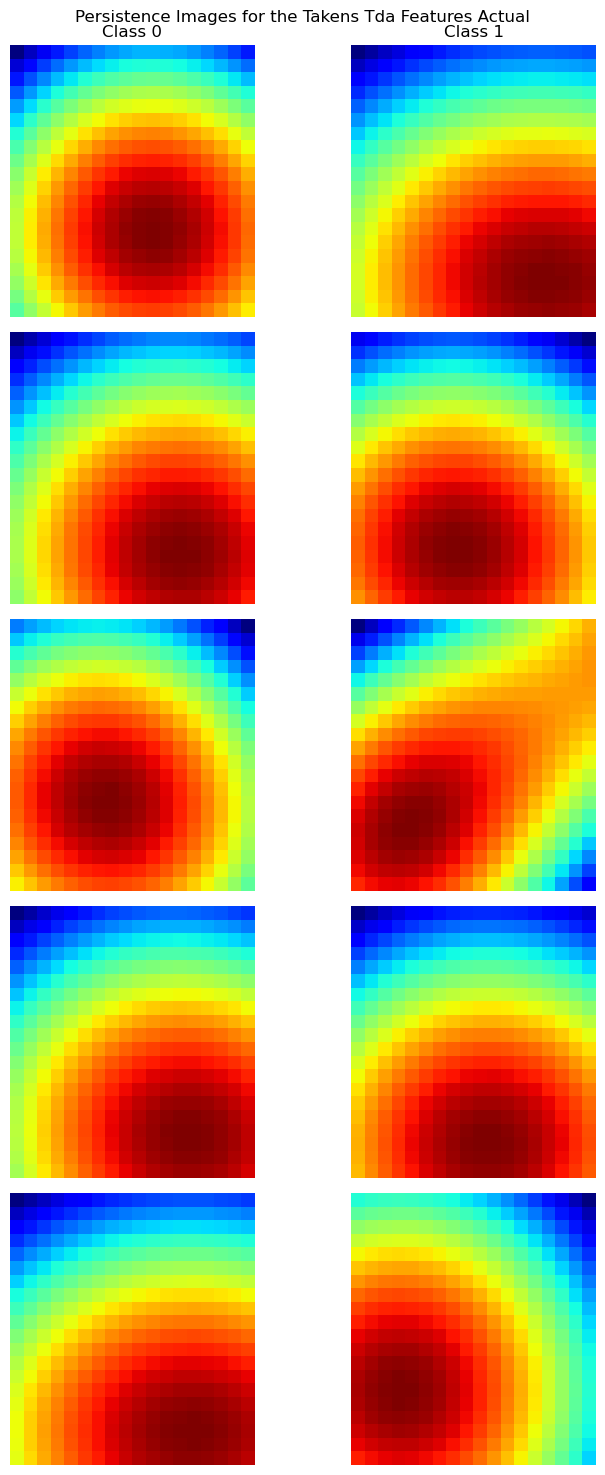

In [14]:
#labels, persistence_images_normalized = get_tda_features_and_labels(df_train)
#plot_persistence_images(labels, persistence_images_normalized, "normalized_data", samples_per_class=5)

# Ensure necessary variables from previous cells are available:
# - df_train (DataFrame of training data, e.g., from df_train_full.copy())
# - feature_methods (dictionary from Cell D, where feature_methods["TDA"] is the TDA extractor function)
# - CLASS_LABELS (binary class map, e.g., {0: 'Normal', 1: 'Seizure'})
# - auto_pi_shape (tuple, e.g., (H, W) for PI dimensions, from Cell C)

print("\n--- Generating and Plotting Actual Persistence Images for TDA (Takens') Features ---")

if 'df_train' in locals() and 'feature_methods' in locals() and 'auto_pi_shape' in locals() and auto_pi_shape is not None:
    
    # 1. Select a Manageable Subset for Visualization (Optional but Recommended)
    #    Generating PIs for the *entire* df_train just for plotting might be slow
    #    if df_train is very large. We only need enough samples to show 
    #    'samples_per_class' for the plot.
    #    Let's aim for slightly more than needed to ensure enough samples per class.
    num_samples_to_plot_total = 50 # Or a number you deem reasonable for visualization
    if len(df_train) > num_samples_to_plot_total:
        # Stratified sampling to try and get representation from both classes
        # This requires scikit-learn's train_test_split for stratified sampling of a subset
        from sklearn.model_selection import train_test_split
        df_plot_subset, _ = train_test_split(
            df_train, 
            test_size=(1 - num_samples_to_plot_total / len(df_train)), # Calculate fraction to discard
            stratify=df_train['y'], # Stratify by your target column
            random_state=42 # For reproducibility of the subset
        )
        print(f"Using a stratified subset of {len(df_plot_subset)} samples from df_train for PI visualization.")
    else:
        df_plot_subset = df_train # Use all if df_train is already small
        print(f"Using all {len(df_plot_subset)} samples from df_train for PI visualization.")

    # 2. Get the TDA Feature Extraction Function
    tda_extractor_func = feature_methods.get("TDA")

    if tda_extractor_func:
        print(f"Attempting to generate Persistence Images for plotting using the configured TDA extractor...")
        try:
            # Call the TDA extractor on the chosen subset (df_plot_subset)
            # This will use FeatureExtractor.get_tda, which uses get_tda_features_from_precomputed_diagrams
            # with the PI parameters set during FeatureExtractor initialization (from auto_pi_params).
            labels_for_plot_pi, persistence_images_flat_for_plot = tda_extractor_func(df_plot_subset)
            
            if persistence_images_flat_for_plot is not None and persistence_images_flat_for_plot.ndim == 2 and persistence_images_flat_for_plot.shape[0] > 0:
                print(f"Successfully generated {persistence_images_flat_for_plot.shape[0]} flat PIs with {persistence_images_flat_for_plot.shape[1]} features each.")

                # 3. Reshape PIs for Plotting
                #    auto_pi_shape was determined in Cell C, e.g., (height, width) like (10, 10) or (20,20)
                pi_height = auto_pi_shape[0]
                pi_width = auto_pi_shape[1]
                
                if persistence_images_flat_for_plot.shape[1] != (pi_height * pi_width):
                    print(f"ERROR: Flattened PI feature count ({persistence_images_flat_for_plot.shape[1]}) "
                          f"does not match expected from auto_pi_shape ({pi_height}x{pi_width}={pi_height * pi_width}). Cannot reshape correctly.")
                else:
                    # Reshape to (num_samples, height, width) for plot_persistence_images
                    persistence_images_reshaped_for_plot = persistence_images_flat_for_plot.reshape(
                        persistence_images_flat_for_plot.shape[0], 
                        pi_height, 
                        pi_width
                    )
                    print(f"Reshaped PIs to: {persistence_images_reshaped_for_plot.shape}")

                    # 4. Plot the Actual Persistence Images
                    #    Ensure visualization.plot_persistence_images is correctly imported
                    from visualization import plot_persistence_images 
                    
                    plot_persistence_images(
                        labels=labels_for_plot_pi, # Numeric labels (0 or 1)
                        persistence_images=persistence_images_reshaped_for_plot, 
                        name="Takens_TDA_Features_Actual", # Descriptive name
                        samples_per_class=5, # How many to show per class in the plot
                        save=True # Optionally save the image
                        # class_labels_map can be passed if plot_persistence_images is modified to use it for titles,
                        # otherwise it might just use "Class 0", "Class 1".
                        # If your plot_persistence_images uses the label directly in the title (e.g. "Class {label}"),
                        # numeric labels are fine.
                    )
            else:
                print("TDA feature extraction did not return valid persistence images for plotting.")
                if persistence_images_flat_for_plot is not None:
                    print(f"  PIs shape: {persistence_images_flat_for_plot.shape}, PIs ndim: {persistence_images_flat_for_plot.ndim}")


        except Exception as e:
            print(f"ERROR during actual PI generation or plotting: {e}")
            import traceback
            traceback.print_exc()
    else:
        print("ERROR: TDA extractor function not found in `feature_methods`.")
else:
    print("Prerequisite variables (df_train, feature_methods, or auto_pi_shape) not available. Skipping actual PI plotting.")

### Function to plot the persistence diagrams

Plotting PDs for 6 selected series.
Saved Takens PD plot to images/Noiseless_Takens_PDs.png


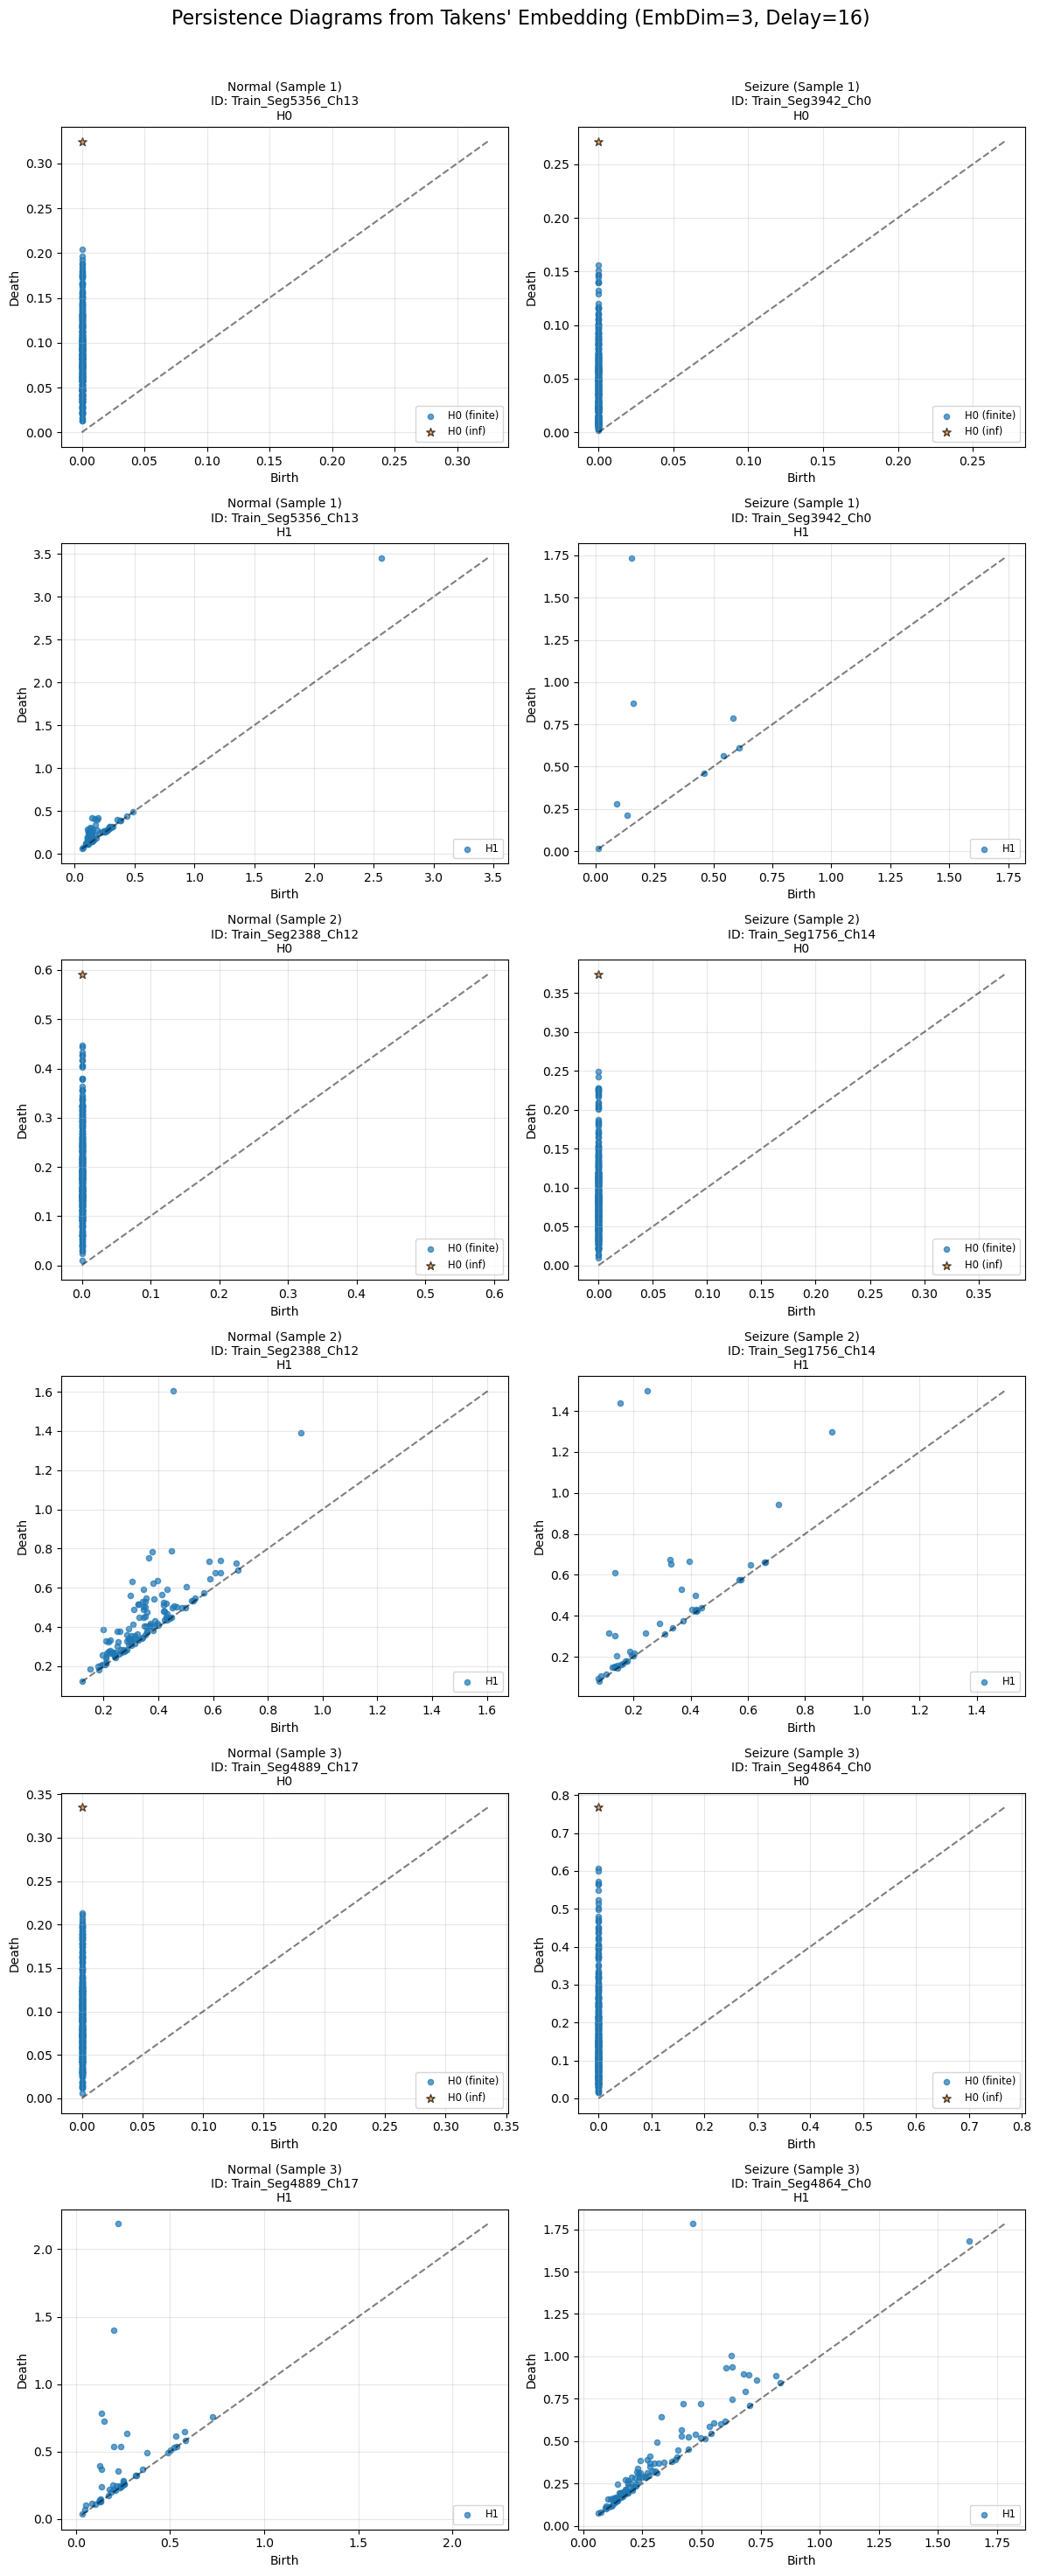

In [15]:
# Assuming the following are defined in your notebook:
# - df_train_full: Your loaded training DataFrame (e.g., from train_data_processed_preexisting_format.csv)
# - predictors: List of your 'X1'...'X500' column names
# - target: Your target column name (e.g., 'y')
# - class_labels_binary: Your map, e.g., {0: 'Normal', 1: 'Seizure'}
# - global_d: Your computed Takens embedding dimension
# - global_tau: Your computed Takens time delay

# Import the modified function (if not already done)
from visualization import plot_takens_persistence_diagrams

# --- Select a subset of data for plotting PDs ---
# This is important because computing PDs for many series can be slow.
n_plot_samples_per_class = 3 # Let's plot 2 samples from each class

# Ensure your target column contains numeric labels (0 and 1)
df_normal_samples_for_plot = df_train_full[df_train_full[target] == 0].sample(n_plot_samples_per_class, random_state=42, replace=False)
df_seizure_samples_for_plot = df_train_full[df_train_full[target] == 1].sample(n_plot_samples_per_class, random_state=42, replace=False)

# Concatenate the samples from both classes
df_plot_subset_pd = pd.concat([df_normal_samples_for_plot, df_seizure_samples_for_plot])
print(f"Plotting PDs for {len(df_plot_subset_pd)} selected series.")

# --- Call the modified plotting function ---
plot_takens_persistence_diagrams(
    df_subset=df_plot_subset_pd,
    predictor_cols=predictors,
    label_col=target,
    id_col='Unnamed',  # Specify the name of your segment ID column
    class_labels_map=class_labels_binary,
    embedding_dim=global_d, 
    time_delay=global_tau,    
    max_homology_dim=1,     # Compute H0 and H1
    samples_per_class=n_plot_samples_per_class, # This is how many from each class in df_plot_subset will be attempted
    plot_dims_to_show=(0, 1), # Show both H0 and H1 diagrams
    save=True, # Optionally save the figure
    figure_name_suffix="Noiseless_Takens_PDs" # Descriptive suffix for the saved file
)

## TRAINING AND HYPERPARAMETER OPTIMIZATION OF DATA WITHOUT NOISE

The next code block is a **setup or configuration step for your entire feature engineering pipeline, especially for the TDA part.**

*   It tells your `FeatureExtractor` *where* to find the already computed diagrams.
*   It tells your `FeatureExtractor` *how* to create Persistence Images from those diagrams (by specifying `pi_params_for_takens`).

If you try to run a Cell that has `run_model_on_features(...)` (or its equivalent) *without* first running this setup block:
*   The `feature_methods` dictionary used by `run_model_on_features` would be created with default parameters (if `get_extractors_methods` in `run_experiments.py` still calls it with no arguments).
*   The `FeatureExtractor` instance wouldn't know about your pre-computed diagrams or your specific PI parameters.
*   Consequently, the TDA feature generation would either fail or not use your pre-computed diagrams and carefully chosen PI settings.

This setup block, should be placed:

1.  **After** you have loaded your main training data (`df_train_full`).
2.  **After** you have successfully run the code that computes and saves `diagrams_takens.joblib` and `labels_takens.joblib`
3.  **Immediately before** the sequence of cells that start calling `run_model_on_features(...)` or the XGBoost specific runners for the *noiseless data analysis*.


In [16]:
# Assuming auto_pi_params, auto_pi_shape, HOMOLOGY_DIM_TO_ANALYZE,
# saved_diagrams_path, saved_labels_path are defined from previous TDA setup cells.

from feature_engineering import get_extractors_methods # Ensure this is the modified version

# Configure pi_config for FeatureExtractor (should not contain 'weight' or 'n_jobs' if using defaults)
pi_config_for_FE = auto_pi_params.copy()
pi_config_for_FE.pop('weight', None) 
pi_config_for_FE.pop('n_jobs', None)

feature_methods_dict = get_extractors_methods(
    scale=True, # Or False if your CSV data is already perfectly scaled and FeatureExtractor shouldn't rescale
    diagrams_path=saved_diagrams_path,
    labels_path=saved_labels_path,
    pi_params=pi_config_for_FE,
    pi_hom_dim=HOMOLOGY_DIM_TO_ANALYZE,
    pi_shape_tuple=auto_pi_shape 
)
print("`feature_methods_dict` created with TDA configuration.")

FeatureExtractor initialized with PI params: {'birth_range': (0.051336294189095494, 1.2789472341537476), 'pers_range': (3.8743019104003906e-07, 1.1612277626991272), 'pixel_size': 0.0613805469982326}
FeatureExtractor initialized with PI homology dim: 1
FeatureExtractor initialized with PI shape: (20, 18)
FeatureExtractor: Loading precomputed diagrams from tda_outputs/diagrams_takens.joblib
FeatureExtractor: Loading precomputed labels from tda_outputs/labels_takens.joblib
FeatureExtractor: Precomputed TDA data loaded successfully.
`feature_methods_dict` created with TDA configuration.


--- Starting Iterative Testing for Model: Logistic Regression ---
--- Target Feature Types: ['Baseline', 'Wavelet', 'TDA', 'FFT'] ---
--- Using n_jobs=1 in GridSearchCV (as per ml_pipeline.py modification) ---

PROCESSING: Model='Logistic Regression', Feature Type='Baseline'
  Calling run_model_on_features for 'Baseline'...

=== Logistic Regression on Baseline Features ===
  Generating Baseline features for TRAINING data (133209 samples)...
  Training features generated: X_train_all shape (133209, 500), y_train_all shape (133209,)
  Generating Baseline features for TEST data (14801 samples)...
  Test features generated: X_test shape (14801, 500), y_test shape (14801,)
  Splitting training features into train_for_gridsearch and validation_for_metrics (ratio: 80%/20%)...
  Splitting full training data (X shape: (133209, 500), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 500)
    Validation set shape: (26642, 500)
    X_train_for_gr

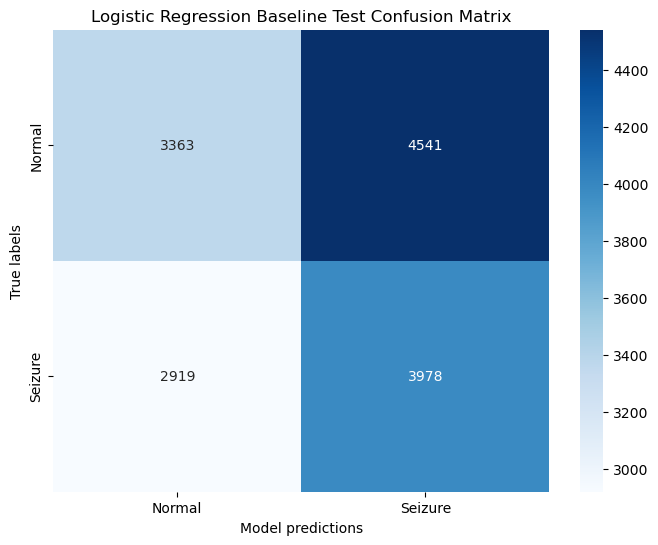

--- COMPLETED: Model='Logistic Regression', Feature Type='Baseline' ---


PROCESSING: Model='Logistic Regression', Feature Type='Wavelet'
  Calling run_model_on_features for 'Wavelet'...

=== Logistic Regression on Wavelet Features ===
  Generating Wavelet features for TRAINING data (133209 samples)...
  Training features generated: X_train_all shape (133209, 36), y_train_all shape (133209,)
  Generating Wavelet features for TEST data (14801 samples)...
  Test features generated: X_test shape (14801, 36), y_test shape (14801,)
  Splitting training features into train_for_gridsearch and validation_for_metrics (ratio: 80%/20%)...
  Splitting full training data (X shape: (133209, 36), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 36)
    Validation set shape: (26642, 36)
    X_train_for_gridsearch shape: (106567, 36)
    X_val_for_metrics shape: (26642, 36)
  Starting model training and tuning for Logistic Regression with Wavelet fea

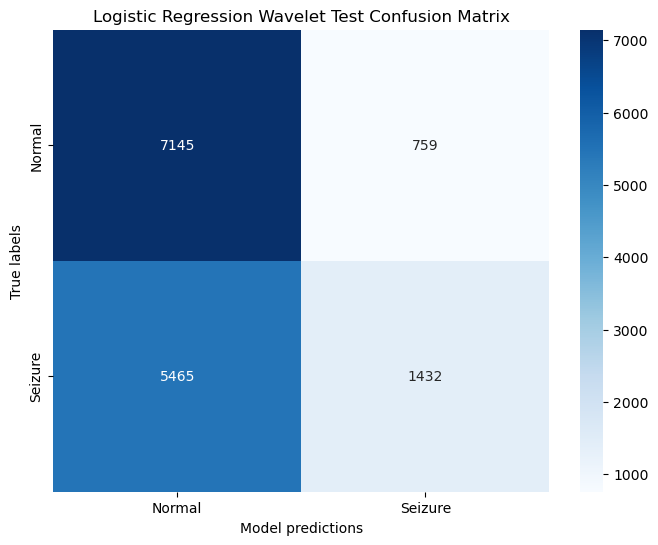

--- COMPLETED: Model='Logistic Regression', Feature Type='Wavelet' ---


PROCESSING: Model='Logistic Regression', Feature Type='TDA'
  Calling run_model_on_features for 'TDA'...

=== Logistic Regression on TDA Features ===
  Generating TDA features for TRAINING data (133209 samples)...
DEBUG: PersistenceImager initialized with effective config: {'birth_range': (0.051336294189095494, 1.2789472341537476), 'pers_range': (3.8743019104003906e-07, 1.1612277626991272), 'pixel_size': 0.0613805469982326}
DEBUG: Dynamically determined actual_pi_shape from pim.transform(dummy_dgm): (20, 18)
DEBUG: Processing 133209 series for PI generation...
  Generated PIs for 1000/133209 series...
  Generated PIs for 2000/133209 series...
  Generated PIs for 3000/133209 series...
  Generated PIs for 4000/133209 series...
  Generated PIs for 5000/133209 series...
  Generated PIs for 6000/133209 series...
  Generated PIs for 7000/133209 series...
  Generated PIs for 8000/133209 series...
  Generated PIs for 9000

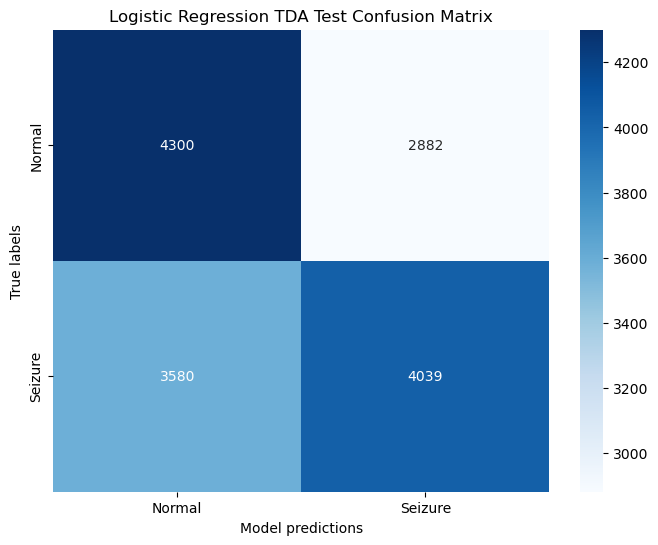

--- COMPLETED: Model='Logistic Regression', Feature Type='TDA' ---


PROCESSING: Model='Logistic Regression', Feature Type='FFT'
  Calling run_model_on_features for 'FFT'...

=== Logistic Regression on FFT Features ===
  Generating FFT features for TRAINING data (133209 samples)...
  Training features generated: X_train_all shape (133209, 250), y_train_all shape (133209,)
  Generating FFT features for TEST data (14801 samples)...
  Test features generated: X_test shape (14801, 250), y_test shape (14801,)
  Splitting training features into train_for_gridsearch and validation_for_metrics (ratio: 80%/20%)...
  Splitting full training data (X shape: (133209, 250), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 250)
    Validation set shape: (26642, 250)
    X_train_for_gridsearch shape: (106567, 250)
    X_val_for_metrics shape: (26642, 250)
  Starting model training and tuning for Logistic Regression with FFT features...
    INFO: [Lo

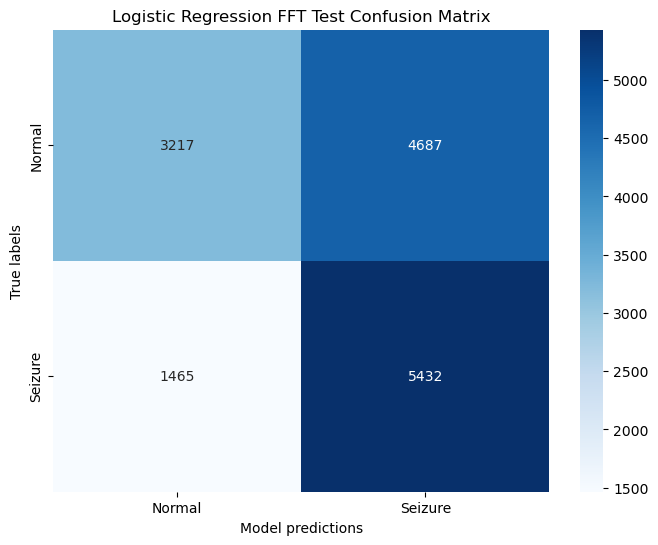

--- COMPLETED: Model='Logistic Regression', Feature Type='FFT' ---


--- Finished Iterative Testing for Model: Logistic Regression ---


In [18]:
### TESTING CELL
### FOR LOOPING THROUGH THE FEATURES

# In a new Notebook Cell

# --- Configuration for this Test Run ---
MODEL_TO_TEST_NAME = "Logistic Regression"
MODEL_TO_TEST_RUN_FUNCTION = run_logistic_regression # The actual function object

# Define the order in which you want to test feature types
# This ensures Baseline (often quickest) runs first if you're debugging iteratively.
FEATURE_TYPES_TO_ITERATE = ["Baseline", "Wavelet", "TDA", "FFT"] 

# Common parameters for run_model_on_features
VAL_SPLIT_RATIO_FOR_LOOP = 0.20
RANDOM_STATE_FOR_LOOP_SPLIT = 42

print(f"--- Starting Iterative Testing for Model: {MODEL_TO_TEST_NAME} ---")
print(f"--- Target Feature Types: {FEATURE_TYPES_TO_ITERATE} ---")
print(f"--- Using n_jobs=1 in GridSearchCV (as per ml_pipeline.py modification) ---")

# Ensure prerequisite variables are loaded (robustness check)
if 'df_train_full' not in locals() or \
   'df_test_full' not in locals() or \
   'feature_methods_dict' not in locals() or \
   MODEL_TO_TEST_RUN_FUNCTION is None or \
   'CLASS_LABELS_BINARY_MAP' not in locals():
    
    print("ERROR: One or more prerequisite variables (df_train_full, df_test_full, "
          "feature_methods_dict, model function, or class map) are not defined. Halting test loop.")
else:
    for feature_name_to_test in FEATURE_TYPES_TO_ITERATE:
        print(f"\n======================================================================")
        print(f"PROCESSING: Model='{MODEL_TO_TEST_NAME}', Feature Type='{feature_name_to_test}'")
        print(f"======================================================================")

        if feature_name_to_test not in feature_methods_dict:
            print(f"SKIPPING: Feature type '{feature_name_to_test}' not found in feature_methods_dict.")
            continue

        # Create a temporary feature_methods dictionary containing only the current feature type
        current_single_feature_dict = {feature_name_to_test: feature_methods_dict[feature_name_to_test]}

        try:
            print(f"  Calling run_model_on_features for '{feature_name_to_test}'...")
            run_model_on_features(
                df_train_input=df_train_full, 
                df_test_input=df_test_full, 
                model_name=MODEL_TO_TEST_NAME, 
                run_model_fn=MODEL_TO_TEST_RUN_FUNCTION,
                feature_methods_dict=current_single_feature_dict, # Pass dict with only ONE feature
                val_split_ratio=VAL_SPLIT_RATIO_FOR_LOOP,
                random_state_split=RANDOM_STATE_FOR_LOOP_SPLIT,
                class_labels_map=CLASS_LABELS_BINARY_MAP
            )
            print(f"--- COMPLETED: Model='{MODEL_TO_TEST_NAME}', Feature Type='{feature_name_to_test}' ---\n")
            
        except SystemExit:
            print(f"CRITICAL: Kernel appeared to be dying or SystemExit caught during '{feature_name_to_test}'. Stopping loop.")
            break # Exit the loop if a critical error seems to have occurred
        except MemoryError:
            print(f"CRITICAL: MemoryError caught during '{feature_name_to_test}'. Stopping loop.")
            # Log this specific error
            break
        except Exception as e:
            print(f"ERROR during processing for Model='{MODEL_TO_TEST_NAME}', Feature Type='{feature_name_to_test}': {e}")
            import traceback
            traceback.print_exc()
            print(f"--- FAILED: Model='{MODEL_TO_TEST_NAME}', Feature Type='{feature_name_to_test}'. Continuing to next feature type if any. ---\n")
            # Decide if you want to 'continue' or 'break' on general exceptions.
            # For debugging kernel crashes, any error is suspicious.
            # However, a kernel crash won't be caught by this 'except Exception'.
            # This try-except is more for catching Python-level errors within a successful feature run.

    print(f"\n--- Finished Iterative Testing for Model: {MODEL_TO_TEST_NAME} ---")

DEBUG: Using df_train_debug_sample shape: (10000, 502)
--- Preparing to run Logistic Regression with modified run_model_on_features ---

=== Logistic Regression on Baseline Features ===
  Generating Baseline features for TRAINING data (10000 samples)...
  Training features generated: X_train_all shape (10000, 500), y_train_all shape (10000,)
  Generating Baseline features for TEST data (2000 samples)...
  Test features generated: X_test shape (2000, 500), y_test shape (2000,)
  Splitting training features into train_for_gridsearch and validation_for_metrics (ratio: 80%/20%)...
  Splitting full training data (X shape: (10000, 500), y shape: (10000,)) into train/validation with val_size=0.2...
    Final Training set shape: (8000, 500)
    Validation set shape: (2000, 500)
    X_train_for_gridsearch shape: (8000, 500)
    X_val_for_metrics shape: (2000, 500)
  Starting model training and tuning for Logistic Regression with Baseline features...
    INFO: [Logistic Regression Baseline] Usin

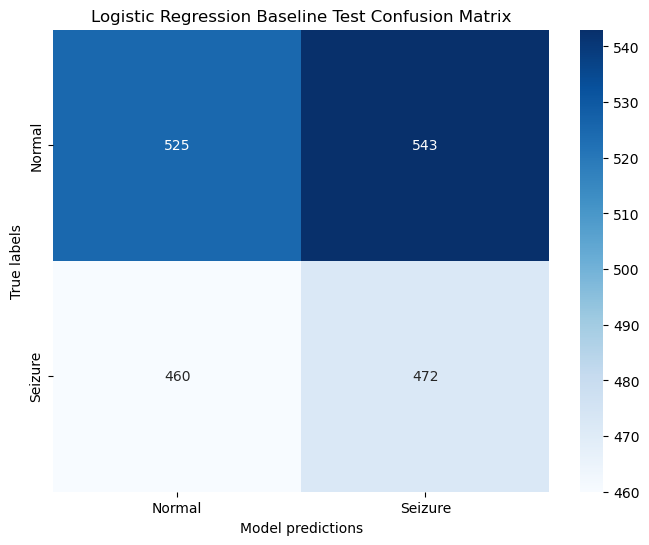


=== Logistic Regression on Wavelet Features ===
  Generating Wavelet features for TRAINING data (10000 samples)...
  Training features generated: X_train_all shape (10000, 36), y_train_all shape (10000,)
  Generating Wavelet features for TEST data (2000 samples)...
  Test features generated: X_test shape (2000, 36), y_test shape (2000,)
  Splitting training features into train_for_gridsearch and validation_for_metrics (ratio: 80%/20%)...
  Splitting full training data (X shape: (10000, 36), y shape: (10000,)) into train/validation with val_size=0.2...
    Final Training set shape: (8000, 36)
    Validation set shape: (2000, 36)
    X_train_for_gridsearch shape: (8000, 36)
    X_val_for_metrics shape: (2000, 36)
  Starting model training and tuning for Logistic Regression with Wavelet features...
    INFO: [Logistic Regression Wavelet] Using scalable SGDClassifier for Logistic Regression.
    DEBUG: [Logistic Regression Wavelet] train_and_tune_model: X_train shape before GS.fit: (8000,

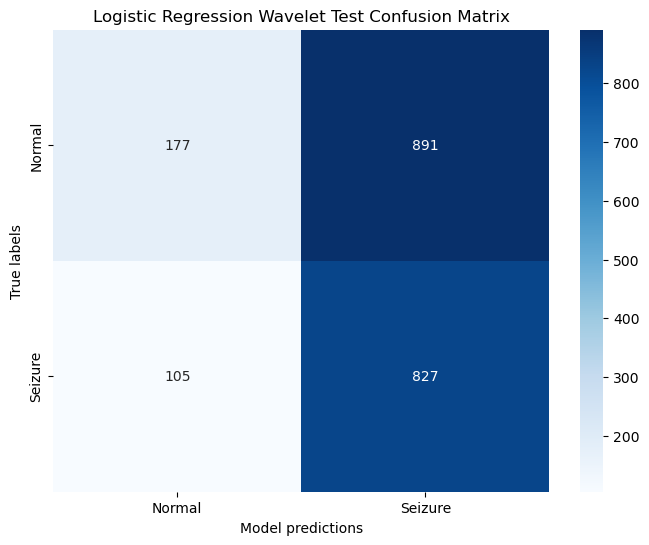


=== Logistic Regression on TDA Features ===
  Generating TDA features for TRAINING data (10000 samples)...
DEBUG: PersistenceImager initialized with effective config: {'birth_range': (0.051336294189095494, 1.2789472341537476), 'pers_range': (3.8743019104003906e-07, 1.1612277626991272), 'pixel_size': 0.0613805469982326}
DEBUG: Dynamically determined actual_pi_shape from pim.transform(dummy_dgm): (20, 18)
DEBUG: Processing 10000 series for PI generation...
  Generated PIs for 1000/10000 series...
  Generated PIs for 2000/10000 series...
  Generated PIs for 3000/10000 series...
  Generated PIs for 4000/10000 series...
  Generated PIs for 5000/10000 series...
  Generated PIs for 6000/10000 series...
  Generated PIs for 7000/10000 series...
  Generated PIs for 8000/10000 series...
  Generated PIs for 9000/10000 series...
  Generated PIs for 10000/10000 series...
Finished PI generation. Total PIs: 10000
  Training features generated: X_train_all shape (10000, 360), y_train_all shape (10000,

/home/ab/miniconda3/envs/seizure_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


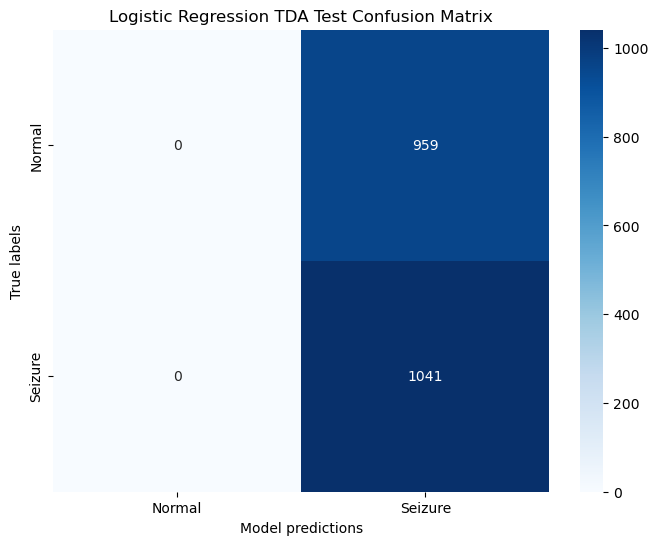


=== Logistic Regression on FFT Features ===
  Generating FFT features for TRAINING data (10000 samples)...
  Training features generated: X_train_all shape (10000, 250), y_train_all shape (10000,)
  Generating FFT features for TEST data (2000 samples)...
  Test features generated: X_test shape (2000, 250), y_test shape (2000,)
  Splitting training features into train_for_gridsearch and validation_for_metrics (ratio: 80%/20%)...
  Splitting full training data (X shape: (10000, 250), y shape: (10000,)) into train/validation with val_size=0.2...
    Final Training set shape: (8000, 250)
    Validation set shape: (2000, 250)
    X_train_for_gridsearch shape: (8000, 250)
    X_val_for_metrics shape: (2000, 250)
  Starting model training and tuning for Logistic Regression with FFT features...
    INFO: [Logistic Regression FFT] Using scalable SGDClassifier for Logistic Regression.
    DEBUG: [Logistic Regression FFT] train_and_tune_model: X_train shape before GS.fit: (8000, 250), y_train sh

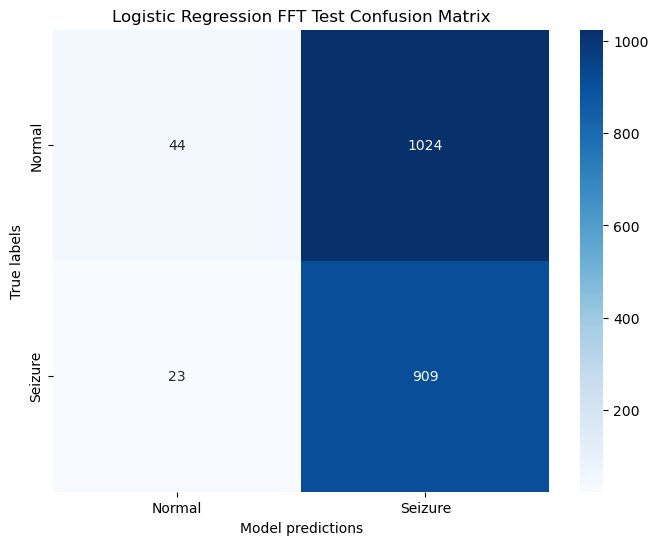

In [19]:
### TESTING CELL
### FOR SMALL DATASET
n_train_sample_debug = 10000 
n_test_sample_debug = 2000

if len(df_train_full) > n_train_sample_debug:
    df_train_debug_sample, _ = train_test_split(df_train_full, train_size=n_train_sample_debug, stratify=df_train_full['y'], random_state=42)
else:
    df_train_debug_sample = df_train_full.copy()

if len(df_test_full) > n_test_sample_debug:
    df_test_debug_sample, _ = train_test_split(df_test_full, train_size=n_test_sample_debug, stratify=df_test_full['y'], random_state=42)
else:
    df_test_debug_sample = df_test_full.copy()
    
print(f"DEBUG: Using df_train_debug_sample shape: {df_train_debug_sample.shape}")
# ... then call run_model_on_features with these debug samples ...


from run_experiments import run_model_on_features, run_logistic_regression # Ensure imports

print("--- Preparing to run Logistic Regression with modified run_model_on_features ---")
if 'df_train_full' in locals() and \
   'df_test_full' in locals() and \
   'feature_methods_dict' in locals() and \
   'run_logistic_regression' in globals() and \
   'CLASS_LABELS_BINARY_MAP' in locals():

    try:
        run_model_on_features(
            df_train_input=df_train_debug_sample, 
            df_test_input=df_test_debug_sample, 
            model_name="Logistic Regression", 
            run_model_fn=run_logistic_regression,
            feature_methods_dict=feature_methods_dict,
            val_split_ratio=0.20, 
            random_state_split=42,
            class_labels_map=CLASS_LABELS_BINARY_MAP
        )
    except TypeError as te:
        print(f"Still encountered a TypeError: {te}")
        print("ACTION: Please ensure you have RESTARTED THE JUPYTER KERNEL and re-run import cells after modifying run_experiments.py.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Skipping Logistic Regression run: One or more required variables "
          "(df_train_full, df_test_full, feature_methods_dict, run_logistic_regression, CLASS_LABELS_BINARY_MAP) not found.")

#### Logistic Regression with different extractors

--- Preparing to run Logistic Regression with modified run_model_on_features ---

=== Logistic Regression on Baseline Features ===
  Generating Baseline features for TRAINING data (133209 samples)...
  Training features generated: X_train_all shape (133209, 500), y_train_all shape (133209,)
  Generating Baseline features for TEST data (14801 samples)...
  Test features generated: X_test shape (14801, 500), y_test shape (14801,)
  Splitting training features into train_for_gridsearch and validation_for_metrics (ratio: 80%/20%)...
  Splitting full training data (X shape: (133209, 500), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 500)
    Validation set shape: (26642, 500)
    X_train_for_gridsearch shape: (106567, 500)
    X_val_for_metrics shape: (26642, 500)
  Starting model training and tuning for Logistic Regression with Baseline features...
    INFO: [Logistic Regression Baseline] Using scalable SGDClassifier for Logistic Reg

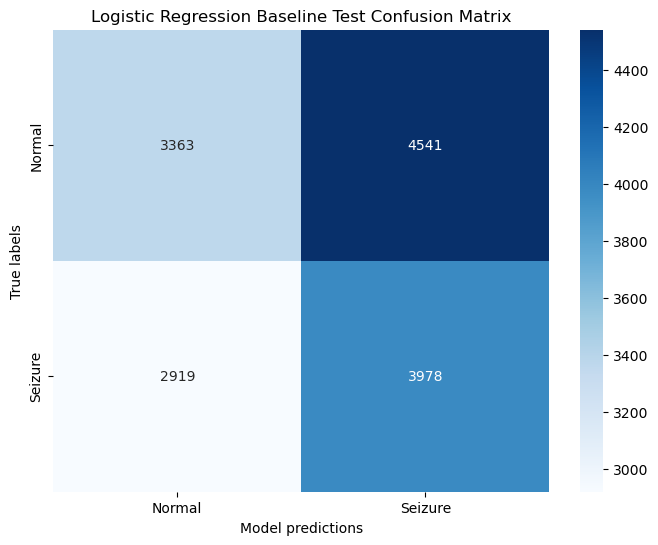


=== Logistic Regression on Wavelet Features ===
  Generating Wavelet features for TRAINING data (133209 samples)...
  Training features generated: X_train_all shape (133209, 36), y_train_all shape (133209,)
  Generating Wavelet features for TEST data (14801 samples)...
  Test features generated: X_test shape (14801, 36), y_test shape (14801,)
  Splitting training features into train_for_gridsearch and validation_for_metrics (ratio: 80%/20%)...
  Splitting full training data (X shape: (133209, 36), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 36)
    Validation set shape: (26642, 36)
    X_train_for_gridsearch shape: (106567, 36)
    X_val_for_metrics shape: (26642, 36)
  Starting model training and tuning for Logistic Regression with Wavelet features...
    INFO: [Logistic Regression Wavelet] Using scalable SGDClassifier for Logistic Regression.
    DEBUG: [Logistic Regression Wavelet] train_and_tune_model: X_train shape before 

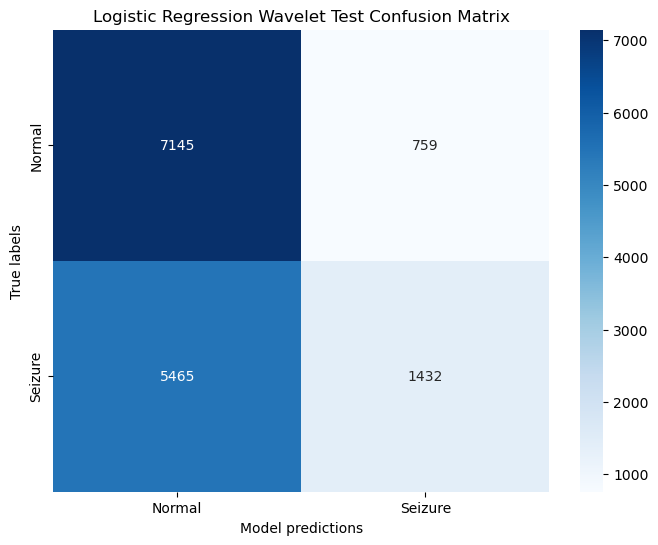


=== Logistic Regression on TDA Features ===
  Generating TDA features for TRAINING data (133209 samples)...
DEBUG: PersistenceImager initialized with effective config: {'birth_range': (0.051336294189095494, 1.2789472341537476), 'pers_range': (3.8743019104003906e-07, 1.1612277626991272), 'pixel_size': 0.0613805469982326}
DEBUG: Dynamically determined actual_pi_shape from pim.transform(dummy_dgm): (20, 18)
DEBUG: Processing 133209 series for PI generation...
  Generated PIs for 1000/133209 series...
  Generated PIs for 2000/133209 series...
  Generated PIs for 3000/133209 series...
  Generated PIs for 4000/133209 series...
  Generated PIs for 5000/133209 series...
  Generated PIs for 6000/133209 series...
  Generated PIs for 7000/133209 series...
  Generated PIs for 8000/133209 series...
  Generated PIs for 9000/133209 series...
  Generated PIs for 10000/133209 series...
  Generated PIs for 11000/133209 series...
  Generated PIs for 12000/133209 series...
  Generated PIs for 13000/13320

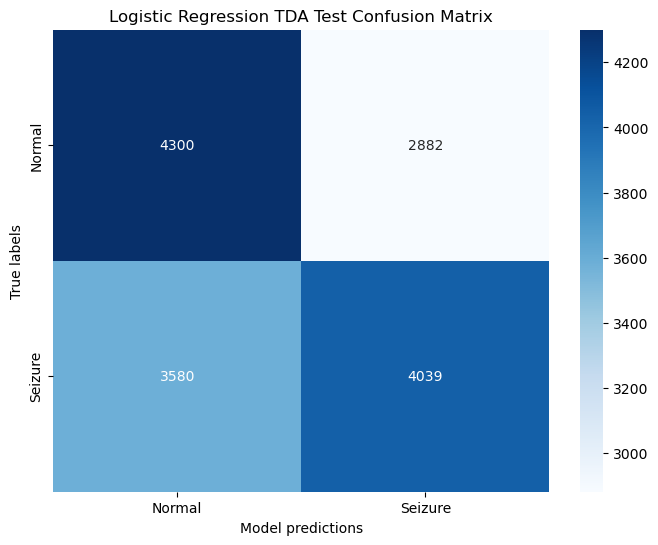


=== Logistic Regression on FFT Features ===
  Generating FFT features for TRAINING data (133209 samples)...
  Training features generated: X_train_all shape (133209, 250), y_train_all shape (133209,)
  Generating FFT features for TEST data (14801 samples)...
  Test features generated: X_test shape (14801, 250), y_test shape (14801,)
  Splitting training features into train_for_gridsearch and validation_for_metrics (ratio: 80%/20%)...
  Splitting full training data (X shape: (133209, 250), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 250)
    Validation set shape: (26642, 250)
    X_train_for_gridsearch shape: (106567, 250)
    X_val_for_metrics shape: (26642, 250)
  Starting model training and tuning for Logistic Regression with FFT features...
    INFO: [Logistic Regression FFT] Using scalable SGDClassifier for Logistic Regression.
    DEBUG: [Logistic Regression FFT] train_and_tune_model: X_train shape before GS.fit: (106567, 

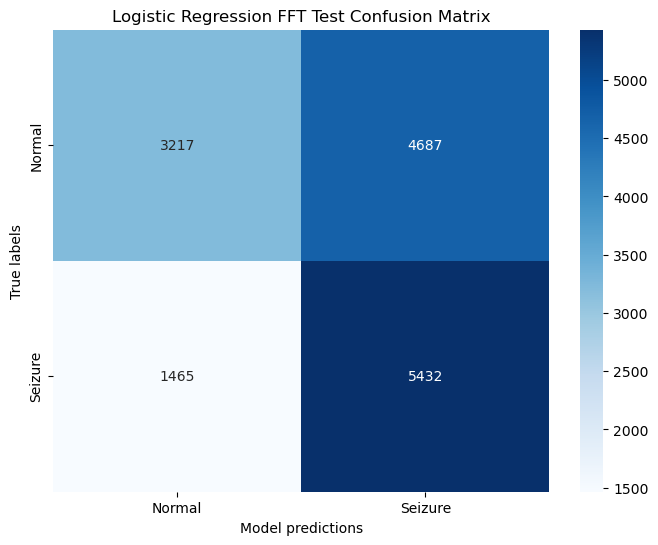

In [20]:
#run_model_on_features(df_train, "Logistic Regression", run_logistic_regression)

# Assuming df_train_full, df_test_full, run_logistic_regression (from run_experiments),
# feature_methods_dict, and CLASS_LABELS_BINARY_MAP are defined.

from run_experiments import run_model_on_features, run_logistic_regression # Ensure imports

print("--- Preparing to run Logistic Regression with modified run_model_on_features ---")
if 'df_train_full' in locals() and \
   'df_test_full' in locals() and \
   'feature_methods_dict' in locals() and \
   'run_logistic_regression' in globals() and \
   'CLASS_LABELS_BINARY_MAP' in locals():

    try:
        run_model_on_features(
            df_train_input=df_train_full, 
            df_test_input=df_test_full, 
            model_name="Logistic Regression", 
            run_model_fn=run_logistic_regression,
            feature_methods_dict=feature_methods_dict,
            val_split_ratio=0.20, 
            random_state_split=42,
            class_labels_map=CLASS_LABELS_BINARY_MAP
        )
    except TypeError as te:
        print(f"Still encountered a TypeError: {te}")
        print("ACTION: Please ensure you have RESTARTED THE JUPYTER KERNEL and re-run import cells after modifying run_experiments.py.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Skipping Logistic Regression run: One or more required variables "
          "(df_train_full, df_test_full, feature_methods_dict, run_logistic_regression, CLASS_LABELS_BINARY_MAP) not found.")

#### RidgeClassifier

In [ ]:
#run_model_on_features(df_train, "Ridge Classifier", run_ridge_classifier)

print("--- Running Ridge Classifier (Noiseless Data) ---")
if 'df_train_full' in locals() and \
   'df_test_full' in locals() and \
   'feature_methods_dict' in locals() and \
   'run_ridge_classifier' in globals() and \
   'CLASS_LABELS_BINARY_MAP' in locals():

    try:
        run_model_on_features(
            df_train_input=df_train_full, 
            df_test_input=df_test_full, 
            model_name="Ridge Classifier", 
            run_model_fn=run_ridge_classifier,
            feature_methods_dict=feature_methods_dict,
            val_split_ratio=0.20, 
            random_state_split=42,
            class_labels_map=CLASS_LABELS_BINARY_MAP
        )
    except Exception as e:
        print(f"ERROR during Ridge Classifier run: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Skipping Ridge Classifier run: One or more required variables not found.")
    

#### SGD Classifier


In [ ]:
#run_model_on_features(df_train, "SGD Classifier", run_sgd_classifier)

print("--- Running SGD Classifier (Noiseless Data) ---")
if 'df_train_full' in locals() and \
   'df_test_full' in locals() and \
   'feature_methods_dict' in locals() and \
   'run_sgd_classifier' in globals() and \
   'CLASS_LABELS_BINARY_MAP' in locals():

    try:
        run_model_on_features(
            df_train_input=df_train_full, 
            df_test_input=df_test_full, 
            model_name="SGD Classifier", 
            run_model_fn=run_sgd_classifier,
            feature_methods_dict=feature_methods_dict,
            val_split_ratio=0.20, 
            random_state_split=42,
            class_labels_map=CLASS_LABELS_BINARY_MAP
        )
    except Exception as e:
        print(f"ERROR during SGD Classifier run: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Skipping SGD Classifier run: One or more required variables not found.")

--- Running SGD Classifier (Noiseless Data) ---

=== SGD Classifier on Baseline Features ===
  Generating Baseline features for TRAINING data (133209 samples)...
  Training features generated: X_train_all shape (133209, 500), y_train_all shape (133209,)
  Generating Baseline features for TEST data (14801 samples)...
  Test features generated: X_test shape (14801, 500), y_test shape (14801,)
  Splitting training features into train_for_gridsearch and validation_for_metrics (ratio: 80%/20%)...
  Splitting full training data (X shape: (133209, 500), y shape: (133209,)) into train/validation with val_size=0.2...
    Final Training set shape: (106567, 500)
    Validation set shape: (26642, 500)
    X_train_for_gridsearch shape: (106567, 500)
    X_val_for_metrics shape: (26642, 500)
  Starting model training and tuning for SGD Classifier with Baseline features...
    DEBUG: [SGD Classifier Baseline] train_and_tune_model: X_train shape before GS.fit: (106567, 500), y_train shape: (106567,)
 

#### SVC Classifier


In [ ]:
#run_model_on_features(df_train, "SVC Classifier", run_svc_classifier)

print("--- Running SVC Classifier (Noiseless Data) ---")
if 'df_train_full' in locals() and \
   'df_test_full' in locals() and \
   'feature_methods_dict' in locals() and \
   'run_svc_classifier' in globals() and \
   'CLASS_LABELS_BINARY_MAP' in locals():

    try:
        run_model_on_features(
            df_train_input=df_train_full, 
            df_test_input=df_test_full, 
            model_name="SVC Classifier", 
            run_model_fn=run_svc_classifier,
            feature_methods_dict=feature_methods_dict,
            val_split_ratio=0.20, 
            random_state_split=42,
            class_labels_map=CLASS_LABELS_BINARY_MAP
        )
    except Exception as e:
        print(f"ERROR during SVC Classifier run: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Skipping SVC Classifier run: One or more required variables not found.")

#### KNN Classifier

In [ ]:
#run_model_on_features(df_train, "KNN Classifier", run_knn_classifier)

print("--- Running KNN Classifier (Noiseless Data) ---")
if 'df_train_full' in locals() and \
   'df_test_full' in locals() and \
   'feature_methods_dict' in locals() and \
   'run_knn_classifier' in globals() and \
   'CLASS_LABELS_BINARY_MAP' in locals():

    try:
        run_model_on_features(
            df_train_input=df_train_full, 
            df_test_input=df_test_full, 
            model_name="KNN Classifier", 
            run_model_fn=run_knn_classifier,
            feature_methods_dict=feature_methods_dict,
            val_split_ratio=0.20, 
            random_state_split=42,
            class_labels_map=CLASS_LABELS_BINARY_MAP
        )
    except Exception as e:
        print(f"ERROR during KNN Classifier run: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Skipping KNN Classifier run: One or more required variables not found.")

#### Random Forest

In [ ]:
#run_model_on_features(df_train, "Random Forest Classifier", run_random_forest_classifier)

print("--- Running Random Forest Classifier (Noiseless Data) ---")
if 'df_train_full' in locals() and \
   'df_test_full' in locals() and \
   'feature_methods_dict' in locals() and \
   'run_random_forest_classifier' in globals() and \
   'CLASS_LABELS_BINARY_MAP' in locals():

    try:
        run_model_on_features(
            df_train_input=df_train_full, 
            df_test_input=df_test_full, 
            model_name="Random Forest Classifier", 
            run_model_fn=run_random_forest_classifier,
            feature_methods_dict=feature_methods_dict,
            val_split_ratio=0.20, 
            random_state_split=42,
            class_labels_map=CLASS_LABELS_BINARY_MAP
        )
    except Exception as e:
        print(f"ERROR during Random Forest Classifier run: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Skipping Random Forest Classifier run: One or more required variables not found.")

#### MLP Classifier

In [ ]:
#run_model_on_features(df_train, "MLP Classifier", run_mlp_classifier)

print("--- Running MLP Classifier (Noiseless Data) ---")
if 'df_train_full' in locals() and \
   'df_test_full' in locals() and \
   'feature_methods_dict' in locals() and \
   'run_mlp_classifier' in globals() and \
   'CLASS_LABELS_BINARY_MAP' in locals():

    try:
        run_model_on_features(
            df_train_input=df_train_full, 
            df_test_input=df_test_full, 
            model_name="MLP Classifier", 
            run_model_fn=run_mlp_classifier,
            feature_methods_dict=feature_methods_dict,
            val_split_ratio=0.20, 
            random_state_split=42,
            class_labels_map=CLASS_LABELS_BINARY_MAP
        )
    except Exception as e:
        print(f"ERROR during MLP Classifier run: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Skipping MLP Classifier run: One or more required variables not found.")

#### XGBoost Classifier

In [ ]:
#run_model_base_dwt_tda_xgboost(df_train)
#run_model_fft_xgboost(df_train)

from run_experiments import run_model_base_dwt_tda_xgboost, run_model_fft_xgboost

print("--- Preparing to run XGBoost with modified specific runners ---")
if 'df_train_full' in locals() and \
   'df_test_full' in locals() and \
   'feature_methods_dict' in locals() and \
   'CLASS_LABELS_BINARY_MAP' in locals():

    # --- Run for Baseline, Wavelet, TDA features ---
    xgboost_bdt_methods = {
        k: feature_methods_dict[k] 
        for k in ["Baseline", "Wavelet", "TDA"] 
        if k in feature_methods_dict
    }
    if xgboost_bdt_methods:
        print("\nRunning XGBoost for Baseline, Wavelet, TDA...")
        try:
            run_model_base_dwt_tda_xgboost(
                df_train_input=df_train_full,
                df_test_input=df_test_full,
                feature_methods_dict_subset=xgboost_bdt_methods,
                val_split_ratio=0.20,
                random_state_split=42,
                class_labels_map=CLASS_LABELS_BINARY_MAP
            )
        except Exception as e:
            print(f"ERROR during run_model_base_dwt_tda_xgboost: {e}")
            import traceback
            traceback.print_exc()
    else:
        print("Required feature methods (Baseline, Wavelet, TDA) not all found for XGBoost BDT run.")

    # --- Run for FFT features ---
    if "FFT" in feature_methods_dict:
        print("\nRunning XGBoost for FFT...")
        try:
            run_model_fft_xgboost(
                df_train_input=df_train_full,
                df_test_input=df_test_full,
                fft_feature_func=feature_methods_dict["FFT"], # Pass the specific function
                val_split_ratio=0.20,
                random_state_split=42,
                class_labels_map=CLASS_LABELS_BINARY_MAP
            )
        except Exception as e:
            print(f"ERROR during run_model_fft_xgboost: {e}")
            import traceback
            traceback.print_exc()
    else:
        print("FFT feature method not found for XGBoost FFT run.")
else:
    print("Skipping XGBoost runs: One or more required variables not found.")

#### CatBoost Classifier

In [ ]:
run_model_on_features(df_train, "CatBoost Classifier", run_catboost_classifier)

## TRAINING AND HYPERPARAMETER OPTIMIZATION OF THE DATA WITH GAUSSIAN NOISE ADDED

In [ ]:
df_viz_gaussian = data.copy()
feature_cols = [x for x in data.columns if x.startswith('X')]
df_viz_gaussian[feature_cols] = df_viz_gaussian[feature_cols].apply(gaussian_noise, percentage=1)
df_viz_gaussian['y'] = df_viz_gaussian['y'].map(class_labels)
X_viz_gaussian = normalize_data(df_viz_gaussian, predictors)  
y_viz_gaussian, _ =  get_features_and_labels(data)  
plot_class_signals(X_viz_gaussian, y_viz_gaussian)

In [ ]:
df_train_gaussian = data.copy()
feature_cols = [x for x in data.columns if x.startswith('X')]
df_train_gaussian[feature_cols] = df_train_gaussian[feature_cols].apply(gaussian_noise, percentage=1)
df_train_gaussian[predictors] = normalize_data(df_train_gaussian, predictors)

## Bottleneck distance (h1)

In [ ]:
diagrams, labels = compute_persistence_diagrams_from_dataframe(df_train_gaussian, maxdim=1)

In [ ]:
target_class = 1  # seizure activity

within_dist = bottleneck_within_class( 
    {k: v['H1'] for k, v in diagrams.items()},  
    labels,
    target_class=target_class
)

print(f"Bottleneck distance within class '{CLASS_LABELS[target_class]}': {within_dist:.4f}")

In [ ]:
class_a = 1
class_b = 4

between_dist = bottleneck_between_class(
    {k: v['H1'] for k, v in diagrams.items()},
    labels,
    class_a,
    class_b
)

print(f"Bottleneck distance between '{CLASS_LABELS[class_a]}' and '{CLASS_LABELS[class_b]}': {between_dist:.4f}")

In [ ]:
plot_persistence_diagrams_from_data(df_train_gaussian, "gaussian_noise_data")

In [ ]:
labels, persistence_images_noisy = get_tda_features_and_labels(df_train_gaussian)
plot_persistence_images(labels, persistence_images_noisy, "gaussian noisy data")


#### KNN (Noisy Data)

In [ ]:
run_model_on_features(df_train_gaussian, "KNN Classifier", run_knn_classifier)

#### Random Forest (Noisy Data)

In [ ]:
run_model_on_features(df_train_gaussian, "Random Forest Classifier", run_random_forest_classifier)

#### XGBoost (Noisy Data)

In [ ]:
run_model_base_dwt_tda_xgboost(df_train_gaussian)
run_model_fft_xgboost(df_train_gaussian)

## TRAINING AND HYPERPARAMETER OPTIMIZATION OF THE DATA WITH ARTIFACT NOISE ADDED

### Spike noise

In [ ]:
df_viz_spike = data.copy()
feature_cols = [x for x in data.columns if x.startswith('X')]

for i, col in enumerate(feature_cols):
    artifact_type = 'spike'
    df_viz_spike[col] = artifact_noise(df_viz_spike[col], 
                                   artifact_type=artifact_type,
                                   percentage=0.99)  
df_viz_spike['y'] = df_viz_spike['y'].map(class_labels) 
X_viz_spike = normalize_data(df_viz_spike, predictors)
y_viz_spike, _ =  get_features_and_labels(data)  

In [ ]:
plot_class_signals(X_viz_spike, y_viz_spike)

In [ ]:
df_train_spike = data.copy()
feature_cols = [x for x in data.columns if x.startswith('X')]

# Add different types of artifacts to different columns
for i, col in enumerate(feature_cols):
    artifact_type = 'spike'
    df_train_spike[col] = artifact_noise(df_train_spike[col], 
                                   artifact_type='spike',
                                   percentage=0.99)  # 99% of points affected

df_train_spike[feature_cols] = normalize_data(df_train_spike, feature_cols)




## Bottleneck Distance (H1)

In [ ]:
diagrams, labels = compute_persistence_diagrams_from_dataframe(df_train_spike, maxdim=1)

In [ ]:
target_class = 1  # seizure activity

within_dist = bottleneck_within_class( 
    {k: v['H1'] for k, v in diagrams.items()},  
    labels,
    target_class=target_class
)

print(f"Bottleneck distance within class '{CLASS_LABELS[target_class]}': {within_dist:.4f}")


In [ ]:
class_a = 1
class_b = 4

between_dist = bottleneck_between_class(
    {k: v['H1'] for k, v in diagrams.items()},
    labels,
    class_a,
    class_b
)

print(f"Bottleneck distance between '{CLASS_LABELS[class_a]}' and '{CLASS_LABELS[class_b]}': {between_dist:.4f}")


### Visualize the Persistence Images of the Artifact Noise Data

In [ ]:
labels, persistence_images_noisy = get_tda_features_and_labels(df_train_spike)
plot_persistence_images(labels, persistence_images_noisy, "artifact_noise_data")


### Visualize the persistence diagrams of the Artifact noise data

In [ ]:
plot_persistence_diagrams_from_data(df_train_spike, "eyeblink_noise_data")

#### KNN (Artifact Noise Data)

In [ ]:
run_model_on_features(df_train_spike, "KNN Classifier", run_knn_classifier)

#### Random Forest (Artifact Noise Data)

In [ ]:
run_model_on_features(df_train_spike, "Random Forest Classifier", run_random_forest_classifier)

#### CatBoost (Artifact Noise Data)

In [ ]:
run_model_on_features(df_train_spike, "CatBoost Classifier", run_catboost_classifier)

#### XGBoost (Artifact Noise Data)

In [ ]:
run_model_base_dwt_tda_xgboost(df_train_spike)
run_model_fft_xgboost(df_train_spike)

### Try with eyeblink

In [ ]:
df_viz_eyeblink = data.copy()
feature_cols = [x for x in df_viz_eyeblink.columns if x.startswith('X')]

for i, col in enumerate(feature_cols):
    artifact_type = 'eyeblink'
    df_viz_eyeblink[col] = artifact_noise(df_viz_eyeblink[col], 
                                   artifact_type=artifact_type,
                                   percentage=0.1)  
df_viz_eyeblink['y'] = df_viz_eyeblink['y'].map(class_labels) 
X_viz_eyeblink = normalize_data(df_viz_eyeblink, predictors)
y_viz_eyeblink, _ =  get_features_and_labels(df_viz_eyeblink)  

In [ ]:
df_train_eyeblink = data.copy()
df_train_eyeblink['Unnamed'] = data['Unnamed']  # if needed

feature_cols = [x for x in df_train_eyeblink.columns if x.startswith('X')]

for col in feature_cols:
    df_train_eyeblink[col] = artifact_noise(df_train_eyeblink[col], artifact_type='eyeblink', percentage=0.99)

df_train_eyeblink[feature_cols] = normalize_data(df_train_eyeblink, feature_cols)

## Bottleneck Distance

In [ ]:
diagrams, labels = compute_persistence_diagrams_from_dataframe(df_train_eyeblink, maxdim=1)

In [ ]:
target_class = 1  # seizure activity

within_dist = bottleneck_within_class( 
    {k: v['H1'] for k, v in diagrams.items()},  
    labels,
    target_class=target_class
)

print(f"Bottleneck distance within class '{CLASS_LABELS[target_class]}': {within_dist:.4f}")

In [ ]:
target_class = 'seizure activity'
within_dist = bottleneck_within_class( 
    {k: v['H1'] for k, v in diagrams.items()},  
    labels,
    target_class=target_class
)

print(f"Bottleneck distance within class '{target_class}': {within_dist:.4f}")

In [ ]:
labels, persistence_images_noisy = get_tda_features_and_labels(df_train_eyeblink)
plot_persistence_images(labels, persistence_images_noisy, "artifact_noise_data")

In [ ]:
plot_persistence_diagrams_from_data(df_train_eyeblink, "eyeblink_noise_data")

In [ ]:
run_model_on_features(df_train_eyeblink, "KNN Classifier", run_knn_classifier)

In [ ]:
run_model_on_features(df_train_eyeblink, "Random Forest Classifier", run_random_forest_classifier)

In [ ]:
run_model_on_features(df_train_eyeblink, "CatBoost Classifier", run_catboost_classifier)

In [ ]:
run_model_base_dwt_tda_xgboost(df_train_eyeblink )
run_model_fft_xgboost(df_train_eyeblink )

## Show Results

### Full Table of Results

In [ ]:
from metrics import load_and_group_metrics, print_metrics_summary, print_model_deltas, print_model_deltas_noisy2
metrics = load_and_group_metrics("metrics")

for ftype, df in metrics.items():
    print(f"\n=== {ftype} Features Metrics Summary ===")
    print(df.to_string())


In [ ]:
print_metrics_summary("metrics")

In [ ]:
models = ['CatBoost', 'KNN', 'Logistic Regression', 'MLP', 'Random Forest', 'Ridge Classifier', 'SGD Classifier', 'SVC', 'XGBoost']
for model in models:
    print_model_deltas(model)


In [ ]:
models = ['CatBoost', 'KNN', 'Logistic Regression', 'MLP', 'Random Forest', 'Ridge Classifier', 'SGD Classifier', 'SVC', 'XGBoost']
for model in models:
    print_model_deltas(model)

In [ ]:
#for model in models:
 #   plot_model_absolute_bars(model)

In [ ]:
models = [ 'CatBoost', 'KNN', 'Random Forest', 'XGBoost']
for model in models:
    result = print_model_deltas_noisy2(model)
    result.to_csv(f"metrics/{model}_deltas_noisy.csv", index=False)